In [1]:
%load_ext autoreload
%autoreload 2

from mecha import networks
from mecha import response_optimization

import numpy as np
import scipy as sp
import networkx as nx
import pandas as pd

from scipy.integrate import solve_ivp

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon
from matplotlib.colors import to_rgba, LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
from matplotlib.animation import FFMpegWriter

import parula

import pickle

import seaborn as sns

In [2]:
cycle = [to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

def flatten_alpha(over, under=np.array([1, 1, 1])):
    over = np.array(over)

    over_col = over[:3]
    over_alpha = over[3]

    return np.concatenate((over_col*over_alpha + under*(1 - over_alpha), [1.0]))

def sample_brillouin(netw, n_samples):
    a, b = netw.graph['periods']
    
    return [np.array([i*np.pi/a, j*np.pi/b])/(n_samples - 1) for i in range(n_samples) for j in range(n_samples)]

def sample_brillouin3d(netw, n_samples):
    a, b, c = netw.graph['periods']
    
    return [np.array([i*np.pi/a, j*np.pi/b, k*np.pi/c])/(n_samples - 1)
            for i in range(n_samples) for j in range(n_samples)
           for k in range(n_samples)]

def gap_sizes_2d(netw, k, opt, n_samples=21, sample_type='normal', sqrt=True,
                return_freqs=False):
    if sample_type == 'deformed':
        samplefun = netw.deformed_spectrum_at
    else:
        samplefun = netw.spectrum_at
    
    a, b = netw.graph['periods']
    
    specs = []
    for qx in np.linspace(-np.pi/a, np.pi/a, n_samples):
        for qy in np.linspace(-np.pi/b, np.pi/b, n_samples):
            q = np.array([qx, qy])
            spec = np.sort(samplefun(k, q))
        
            if sqrt:
                spec = np.sign(spec + 1e-10)*np.sqrt(np.abs(spec))
                
            # find gaps
            specs.append(spec)

    specs = np.array(specs)
    
    try:
        # Optimizer object
        uppers = specs[:,opt.gap_inds+1]
        lowers = specs[:,opt.gap_inds]
    except:
        # array of indices
        uppers = specs[:,opt+1]
        lowers = specs[:,opt]        
    
    min_upper = np.min(uppers, axis=0)
    max_lower = np.max(lowers, axis=0)
    
    if return_freqs:
        return min_upper - max_lower, min_upper, max_lower
    else:
        return min_upper - max_lower
    
def gap_sizes_3d(netw, k, opt, n_samples=11, sample_type='normal', sqrt=True,
                return_freqs=False):
    if sample_type == 'deformed':
        samplefun = netw.deformed_spectrum_at
    else:
        samplefun = netw.spectrum_at
    
    a, b, c = netw.graph['periods']
    
    specs = []
    for qx in np.linspace(-np.pi/a, np.pi/a, n_samples):
        for qy in np.linspace(-np.pi/b, np.pi/b, n_samples):
            for qz in np.linspace(-np.pi/c, np.pi/c, n_samples):
                q = np.array([qx, qy, qz])
                spec = np.sort(samplefun(k, q))

                if sqrt:
                    spec = np.sign(spec + 1e-10)*np.sqrt(np.abs(spec))

                # find gaps
                specs.append(spec)

    specs = np.array(specs)
    
    try:
        # Optimizer object
        uppers = specs[:,opt.gap_inds+1]
        lowers = specs[:,opt.gap_inds]
    except:
        # array of indices
        uppers = specs[:,opt+1]
        lowers = specs[:,opt]        
    
    min_upper = np.min(uppers, axis=0)
    max_lower = np.max(lowers, axis=0)
    
    if return_freqs:
        return min_upper - max_lower, min_upper, max_lower
    else:
        return min_upper - max_lower

def sample_spectrum_along(netw, k, q_initial, q_final, n_samples=40, sqrt=True, sample_type='normal'):
    q_vecs = (q_initial[:,np.newaxis] + (q_final[:, np.newaxis] - q_initial[:,np.newaxis])*np.linspace(0, 1, n_samples)).T
    
    if sample_type == 'deformed':
        samplefun = netw.deformed_spectrum_at
    else:
        samplefun = netw.spectrum_at
    
    spectra = []
    for i in range(q_vecs.shape[0]):
        spec = samplefun(k, q_vecs[i,:])
        
        if sqrt:
            spec = np.sqrt(np.abs(spec))
        
        spectra.append(spec)
        
    dx = np.linalg.norm(q_vecs[1,:] - q_vecs[0,:])
    return np.array(spectra), q_vecs, dx

def sample_bz_spectrum_2d(netw, k, n_samples=31, sqrt=True, sample_type='normal'):
    a, b = netw.graph['periods']
    
    if sample_type == 'deformed':
        samplefun = netw.deformed_spectrum_at
    else:
        samplefun = netw.spectrum_at
    
    spectra = np.array([])
    for qx in np.linspace(-np.pi/a, np.pi/a, n_samples):
        for qy in np.linspace(-np.pi/b, np.pi/b, n_samples):
            q = np.array([qx, qy])
            spec = samplefun(k, q)
            
            if sqrt:
                spec = np.sign(spec + 1e-10)*np.sqrt(np.abs(spec))
                
            spectra = np.concatenate((spectra, spec))
            
    return spectra

def sample_bz_spectrum_3d(netw, k, n_samples=21, sqrt=True):
    a, b, c = netw.graph['periods']
    
    spectra = []
    for qx in np.linspace(0, np.pi/a, n_samples):
        for qy in np.linspace(0, np.pi/b, n_samples):
            for qz in np.linspace(0, np.pi/c, n_samples):
                q = np.array([qx, qy, qz])
                spec = netw.spectrum_at(k, q)

                if sqrt:
                    spec = np.sqrt(np.abs(spec))

                spectra.extend(spec)
            
    return spectra

def plot_spectrum(ax, netw, k, q_points, names, n_samples=20, sample_type='normal', show_gaps=None, 
                  gap_size=gap_sizes_2d, n_samples_gs=81, **kwargs):
    name_pts = [0]
    
    for i in range(len(q_points) - 1):
        spec, q_vecs, dx = sample_spectrum_along(netw, k, q_points[i], q_points[i+1], n_samples=n_samples,
                                                sample_type=sample_type)
        ax.plot(name_pts[i] + dx*np.linspace(0, 1, n_samples), spec, **kwargs)
    
        name_pts.append(name_pts[i] + dx)
    
    # plot gap in orange
    if show_gaps is not None:
        sz, upper, lower = gap_size(netw, k, show_gaps, return_freqs=True,
                                   n_samples=n_samples_gs)
        
        for l, u in zip(lower, upper):
            ax.fill_between([name_pts[0], name_pts[-1]], [l, l], [u, u],
                           color=cycle[1], alpha=0.4, zorder=-100)
    
    # plot separator lines
    for name_pt in name_pts[1:-1]:
        ax.axvline(name_pt, color='k', linewidth=0.66)
    
    # set ticks
    ax.set_xticks(name_pts)
    ax.set_xticklabels(names)
    ax.set_xlim(name_pts[0], name_pts[-1])
    ax.set_ylim(0)
    
    if show_gaps is not None:
        return lower, upper
    else:
        return None, None

    
# default colors
blue = sns.color_palette()[0]
blue_alpha = (blue[0], blue[1], blue[2], 0.8)
spectrum_color = blue_alpha

In [3]:
triang_grid = networks.TriangularGrid2D(n=6, x_periodic=True, y_periodic=True)
qs = sample_brillouin(triang_grid, 4)

opt_triang_grid = response_optimization.PointMassOptimizer(triang_grid, [8], qs)

ret_triang_grid = opt_triang_grid.optimize(seed=48)
ret_triang_grid

(      fun: 0.02290046222011198
  hess_inv: <108x108 LbfgsInvHessProduct with dtype=float64>
       jac: array([ 7.08056860e-03, -3.65449073e-04,  8.66845714e-06,  1.76791688e-03,
        -5.47756466e-04, -7.86727940e-05, -4.70617450e-04,  8.01113707e-03,
        -9.70158080e-05, -1.67081690e-04, -1.79023719e-04, -2.07711897e-04,
        -1.24474865e-04, -1.26938120e-04,  3.66856465e-03,  3.83926374e-06,
        -4.98577896e-05,  6.50009138e-03,  6.10556228e-03, -3.01351003e-04,
        -2.57827263e-04, -3.37804567e-04, -1.93624788e-04, -9.37205597e-05,
        -2.08369538e-05, -1.45123689e-04, -4.75051849e-04, -1.03439310e-04,
         1.32443406e-04, -5.65295533e-04, -1.09805832e-04, -2.78746743e-04,
        -4.03394955e-04, -3.29264230e-04,  2.60101258e-03, -2.95308039e-04,
         5.42799714e-03, -7.13328771e-05, -8.67145138e-04,  1.91260213e-05,
         5.44365460e-04, -3.81455659e-04, -9.82591077e-05, -3.58695722e-04,
        -2.49476034e-04,  6.62198549e-05,  4.87036531e-03, -

In [4]:
triang_3gap = networks.TriangularGrid2D(n=6, x_periodic=True, y_periodic=True)
qs = sample_brillouin(triang_3gap, 4)

opt_triang_3gap = response_optimization.PointMassOptimizer(triang_3gap, [0.2, 0.4, 0.6], qs)

ret_triang_3gap = opt_triang_3gap.optimize(tol=1e-8, seed=42)
ret_triang_3gap

(      fun: 0.1201151086280384
  hess_inv: <108x108 LbfgsInvHessProduct with dtype=float64>
       jac: array([-5.97385822e-03, -4.52514953e-06, -1.47704684e-03, -3.48712498e-06,
         2.18407622e-03,  1.78010138e-02,  5.93976196e-03, -8.60359864e-06,
        -6.19405168e-03, -2.88259506e-03, -5.38480649e-06, -1.33827712e-05,
        -1.92472329e-03, -6.43417316e-06,  8.43502013e-03, -2.36211448e-05,
        -6.21496450e-06, -1.78513181e-05, -5.48885683e-03, -1.48365636e-06,
        -2.51285260e-04, -9.72715655e-07, -2.34206663e-03, -5.14262083e-06,
        -4.28670008e-03,  9.13233536e-06,  1.51179299e-02,  3.49314209e-03,
        -1.38397146e-05,  3.44654756e-05, -4.84200048e-06, -1.37178219e-04,
         2.96627350e-03, -2.63644101e-03, -1.78878791e-04, -2.11763863e-05,
         2.85782358e-02, -1.40258180e-05, -3.79327611e-05, -8.81145712e-06,
         1.84283323e-02, -2.71214903e-05, -1.31493498e-05, -1.21239592e-03,
        -1.16502142e-06, -1.00963670e-05, -1.76038753e-03,  8

In [5]:
np.random.seed(42)
delaunay = networks.DelaunayNetwork(dimension=2, n=36, copy_unit_cell=[0, 1])
delaunay = delaunay.make_periodic()

qs = sample_brillouin(delaunay, 3)

opt_delaunay = response_optimization.PointMassOptimizer(delaunay, [8], qs)

ret_delaunay = opt_delaunay.optimize(seed=42)
ret_delaunay

(      fun: 0.03193470240894062
  hess_inv: <108x108 LbfgsInvHessProduct with dtype=float64>
       jac: array([-7.31007349e-06, -1.42484288e-05, -2.77137496e-04,  2.10018261e-04,
         8.03712983e-03, -6.51004774e-04, -2.02615293e-03, -1.59695983e-03,
        -5.16606448e-04, -1.24325001e-03,  3.62018605e-03,  5.10621742e-05,
         7.09200736e-03,  3.23572500e-03, -3.15507522e-04,  1.23555111e-03,
        -1.37344864e-04, -3.56252074e-04,  1.17253998e-02, -5.89890862e-04,
         1.57625167e-04, -1.05673940e-04,  3.26871202e-03, -1.77761491e-04,
         1.37300901e-02,  6.43538486e-03, -7.63056786e-04,  9.08844270e-05,
        -4.09799450e-04,  1.50926796e-03, -9.34779472e-06,  7.05733596e-04,
         1.00884139e-03, -1.62591750e-04, -1.24167519e-03, -6.77546826e-04,
        -1.24916271e-04, -1.47432367e-03, -3.32305830e-04, -9.71606995e-04,
        -6.72966068e-04, -8.56896353e-04,  4.27876926e-03, -5.02071640e-04,
         7.65892146e-03,  3.02998639e-03, -3.96329598e-04, -

In [6]:
triang3d = networks.TriangularGrid3D(4, copy_unit_cell=[0, 1, 2])
triang3d = triang3d.make_periodic()

qs = sample_brillouin3d(triang3d, 4)

opt_3d = response_optimization.PointMassOptimizer(triang3d, [25], qs)

ret_3d = opt_3d.optimize(seed=42)
ret_3d

(      fun: 0.018035569328136315
  hess_inv: <384x384 LbfgsInvHessProduct with dtype=float64>
       jac: array([-1.64785574e-04, -2.03727680e-04, -1.19587711e-04, -2.72285235e-06,
        -2.73133376e-05, -9.95481037e-06,  6.79777400e-05, -2.77309270e-04,
        -1.69411900e-04,  3.41395155e-05,  3.37492621e-04, -1.76497940e-04,
        -2.40665332e-04,  1.84692310e-03, -2.55046171e-04, -5.52772100e-05,
        -1.86843082e-05, -6.22440788e-04, -2.14072624e-04, -1.18394582e-04,
        -1.65236127e-04,  3.58320852e-04,  1.55512555e-03, -1.42326270e-04,
         3.56819233e-04, -3.64847816e-05,  3.73524015e-04,  1.95733637e-03,
        -1.74846644e-04, -1.94986973e-04,  6.46615027e-08, -9.69021651e-06,
        -3.06877351e-04, -2.11700048e-05, -1.36442775e-04, -2.17451805e-04,
         1.10538002e-06, -2.17112421e-04, -4.74634436e-05, -7.00803749e-05,
         3.00876194e-03, -1.90107428e-04, -3.68092085e-05, -2.39560243e-04,
        -1.32329043e-04,  9.10469773e-06, -6.37404081e-05, 

In [7]:
def plot_result_2d(netw, k, ax_netw, ax_stiff, ax_bands, ax_dos, sample_type='normal', dos_bins=101,
                  show_gaps=None, factor=1):
    a, b = netw.graph['periods']

    Γ = np.array([0, 0])
    M = np.array([0, np.pi/b])
    X = np.array([np.pi/a, np.pi/b])
    blue_muchalpha = flatten_alpha((cycle[0][0], cycle[0][1], cycle[0][2], 0.2))   
    
    # Stiffness histogram
    if ax_stiff is not None:
        ax_stiff.hist(k, range=(0.1, 1.0), bins=21, density=False, histtype='step', orientation='horizontal')
        ax_stiff.set_xlabel('count')
        ax_stiff.xaxis.set_label_position('top') 
        ax_stiff.xaxis.set_ticks_position('top')
        ax_stiff.yaxis.set_label_position('right')
        ax_stiff.yaxis.set_ticks_position('right')
        ax_stiff.set_ylabel('Stiffness $k$', labelpad=-12)
        ax_stiff.set_yticks([0.1, 1.0])
    
    # BZ spectrum
    if ax_dos is not None:
        bz_spec = sample_bz_spectrum_2d(netw, k, sample_type=sample_type)
        ax_dos.hist(bz_spec, bins=dos_bins, density=True, histtype='stepfilled',
                    facecolor=blue_muchalpha, edgecolor=blue_alpha, orientation='horizontal')
#         ax_dos.set_xlabel('ρ(ω)')
        ax_dos.set_ylabel(r"D.o.s. $\rho(\omega)$")
        ax_dos.set_ylim(0)
        ax_dos.yaxis.set_label_position('right')
        ax_dos.yaxis.set_ticks_position('right')
    
    # Network
    if ax_netw is not None:
        a, b = netw.graph['periods']
        netw.draw_edges_2d(factor*3*k, ax_netw, color=blue_alpha)
        ax_netw.set_xlim(0, a)
        ax_netw.set_ylim(0, b)
        ax_netw.set_xticks([])
        ax_netw.set_yticks([])

    # Band structure
    ls, us = plot_spectrum(ax_bands, netw, k, [M, Γ, X, M], ['M', 'Γ', 'X', 'M'], 
                  color=blue_alpha, linewidth=0.7, sample_type=sample_type,
                 show_gaps=show_gaps, n_samples_gs=151)
    ax_bands.set_ylabel('freq.', labelpad=-8)
    
    yticks = ax_bands.get_yticks()
    ax_bands.set_yticks([yticks[0], yticks[-2]])
    
    # mark the gap in the D.O.S.
    if show_gaps is not None and ax_dos is not None:
        ax_dos.set_xlim(*ax_dos.get_xlim())
        for l, u in zip(ls, us):
            ax_dos.fill_between([0, ax_dos.get_xlim()[1]], [l, l], [u, u], color=cycle[1],
                               alpha=0.4, zorder=-100)
    
    
def render_network_3d(netw, ret, figsize=(6, 4)):
    f = plt.figure(figsize=figsize, dpi=300)

    ax1a = f.add_subplot(1, 1, 1, projection='3d')

    ax1a.axis('off')
    netw.draw_edges_3d(5*ret.x, ax1a, color=blue_alpha, plot_periodic=False)

    ax1a.view_init(20, 20)
    ax1a.dist = 6.75

    f.tight_layout(pad=0)
    f.canvas.draw()
#     f.savefig('figures/3d_tmp.png', dpi=600, bbox_inches='tight', pad_inches=0)
    data = np.frombuffer(f.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(f.canvas.get_width_height()[::-1] + (3,))
    
    plt.close(f)
    return data
    
def plot_result_3d(netw, ret, ax_netw, ax_stiff, ax_bands, ax_dos, show_gaps=None, dos_bins=201,
                   n_samples=21,
                  figsize=(6, 4)):
    a, b, c = netw.graph['periods']
    Γ3 = np.array([0,0,0])
    X3 = np.array([a,0,0])
    Y3 = np.array([0,b,0])
    Z3 = np.array([0,0,c])
    T3 = np.array([0,b,c])
    U3 = np.array([a,0,c])
    S3 = np.array([a,b,0])
    R3 = np.array([a,b,c])
    
    blue_muchalpha = flatten_alpha((cycle[0][0], cycle[0][1], cycle[0][2], 0.2))

    # Stiffness histogram
    ax_stiff.hist(ret.x, range=(0.1, 1.0), bins=21, density=False, histtype='step', orientation='horizontal')
    ax_stiff.set_xlabel('count')
    ax_stiff.xaxis.set_label_position('top') 
    ax_stiff.xaxis.set_ticks_position('top') 
    ax_stiff.yaxis.set_label_position('right')
    ax_stiff.yaxis.set_ticks_position('right')
    ax_stiff.set_ylabel('Stiffness $k$', labelpad=-12)
    ax_stiff.set_yticks([0.1, 1.0])
    
    # BZ spectrum
    bz_spec = sample_bz_spectrum_3d(netw, ret.x, n_samples=n_samples)
    ax_dos.hist(bz_spec, bins=dos_bins, density=True, histtype='stepfilled', 
                facecolor=blue_muchalpha, edgecolor=blue_alpha, orientation='horizontal')
    ax_dos.set_ylabel(r'D.o.s. $\rho(\omega)$')    
    ax_dos.set_ylim(0)
    ax_dos.yaxis.set_label_position('right')
    ax_dos.yaxis.set_ticks_position('right')
    
    # Network
    # pre-render network
    img = render_network_3d(netw, ret, figsize=figsize)
    
    ax_netw.imshow(img)
    ax_netw.set_xticks([])
    ax_netw.set_yticks([])
    
    # Band structure
    ls, us = plot_spectrum(ax_bands, netw, ret.x, [Γ3, X3, S3, Y3, Γ3, Z3, U3, R3, T3, Z3,], 
                  ['Γ', 'X', 'S', 'Y', 'Γ', 'Z', 'U', 'R', 'T', 'Z'], 
                  color=blue_alpha, linewidth=0.7,
                 show_gaps=show_gaps, gap_size=gap_sizes_3d, n_samples_gs=31)
    ax_bands.set_ylabel('freq.', labelpad=-8)
    
    # mark the gap in the D.O.S.
    if show_gaps is not None:
        ax_dos.set_xlim(*ax_dos.get_xlim())
        for l, u in zip(ls, us):
            ax_dos.fill_between([0, ax_dos.get_xlim()[1]], [l, l], [u, u], color=cycle[1],
                               alpha=0.4, zorder=-100)
    
    yticks = ax_bands.get_yticks()
    ax_bands.set_yticks([yticks[0], yticks[-2]])

Figure 2: Data Analysis
===

In [7]:
df_triang_4 = pd.read_csv("data/triang_size_4.csv")
df_triang_6 = pd.read_csv("data/triang_size_6.csv")
df_triang_8 = pd.read_csv("data/triang_size_8.csv")

df_dela_4 = pd.read_csv("data/delaunay_size_4.csv")
df_dela_6 = pd.read_csv("data/delaunay_size_6.csv")
# df_dela_8 = pd.read_csv("data/delaunay_size_8.csv")


# df_number_4 = pd.read_csv("data/triang_gap_size_4.csv")
# df_number_6 = pd.read_csv("data/triang_gap_size_6.csv")

df_number_4 = pd.concat([pd.read_csv("data/triang_gap_size_4_107381.csv"),
                       pd.read_csv('data/triang_gap_size_4_215120.csv')])

df_number_6 = pd.concat([pd.read_csv("data/triang_gap_size_6_192763.csv")
                       ])

df_number_4_del = pd.concat([pd.read_csv("data/delaunay_gap_size_4_259562.csv"),
                            ])

df_number_6_del = pd.concat([pd.read_csv("data/delaunay_gap_size_6_400278.csv"),
                       ])

def binomial_std(x):
    n = len(x)
    pi = np.sum(x)/n
    return np.sqrt(pi*(1 - pi)/n)

# triang
df_number_4["success"] = df_number_4["min_gap"] > 0
P_success_4 = df_number_4.groupby("n_gaps").mean()
P_success_std_4 = df_number_4.groupby("n_gaps").agg(binomial_std)

df_number_6["success"] = df_number_6["min_gap"] > 0
P_success_6 = df_number_6.groupby("n_gaps").mean()
P_success_std_6 = df_number_6.groupby("n_gaps").agg(binomial_std)


# delaunay
df_number_4_del["success"] = df_number_4_del["min_gap"] > 0
P_success_4_del = df_number_4_del.groupby("n_gaps").mean()
P_success_std_4_del = df_number_4_del.groupby("n_gaps").agg(binomial_std)

df_number_6_del["success"] = df_number_6_del["min_gap"] > 0
P_success_6_del = df_number_6_del.groupby("n_gaps").mean()
P_success_std_6_del = df_number_6_del.groupby("n_gaps").agg(binomial_std)

/home/henrik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
# robustness

def robustness(netw, gap, samples=11, pert_samples=25):
    triang_grid = netw
    qs = sample_brillouin(triang_grid, 4)

    opt = response_optimization.PointMassOptimizer(triang_grid, gap, qs)
    res, x0 = opt.optimize()
    
    sigmas = np.linspace(0.0, 0.5, samples)
    gap_sizes = []
    gap_sizes_std = []
    for sigma in sigmas:
        gsiz = []
        for i in range(pert_samples):
            perturbed = np.clip(res.x + sigma*np.random.randn(res.x.shape[0]), 0.1, 1.0)
            gsiz.append(np.clip(gap_sizes_2d(triang_grid, perturbed, opt), 0, np.inf))
            
        gap_sizes.append(np.mean(gsiz))
        gap_sizes_std.append(np.std(gsiz, ddof=1)/np.sqrt(pert_samples))
    
    return sigmas, gap_sizes, gap_sizes_std
    
sigmas, pert_8_triang, pert_8_triang_std = robustness(triang_grid, [8])
sigmas, pert_16_triang, pert_16_triang_std = robustness(triang_grid, [16])

sigmas, pert_8_del, pert_8_del_std = robustness(delaunay, [8])
sigmas, pert_16_del, pert_16_del_std = robustness(delaunay, [16])

In [8]:
# with open("data/gap_robustness.pkl", "wb") as f:
#     pickle.dump([ sigmas,
#                 pert_4_triang, pert_4_triang_std,
#                 pert_4_del, pert_4_del_std,
#                 pert_8_triang, pert_8_triang_std,
#                 pert_16_triang, pert_16_triang_std,
#                 pert_8_del, pert_8_del_std,
#                 pert_16_del, pert_16_del_std],
#                f)

# sigmas, pert_4_triang, pert_4_triang_std = robustness(triang_grid, [4])
# sigmas, pert_4_del, pert_4_del_std = robustness(delaunay, [4])

with open("data/gap_robustness.pkl", "rb") as f:
    [ sigmas,
                pert_4_triang, pert_4_triang_std,
                pert_4_del, pert_4_del_std,
                pert_8_triang, pert_8_triang_std,
                pert_16_triang, pert_16_triang_std,
                pert_8_del, pert_8_del_std,
                pert_16_del, pert_16_del_std] = pickle.load(f)

Figure 3: Switching
===

In [9]:
# Open stored results
with open("data/switch_tune_shear.pkl", "rb") as f:
    netw_shear_1, Γ_shear_1, ret_shear_1 = pickle.load(f)
    
# gap index=6
    
with open("data/switch_tune_shear_2.pkl", "rb") as f:
    netw_shear_2, Γ_shear_2, ret_shear_2 = pickle.load(f)
    
# gap index=9
    
Γ_shear_1 = lambda ϵ: np.array([[1.0, ϵ],
              [0, 1.0]])

Γ_shear_2 = lambda ϵ: np.array([[1.0, 0],
              [ϵ, 1.0]])

Γres_shear_1 = Γ_shear_1(0.125)
Γres_shear_2 = Γ_shear_2(0.125)

deformed_shear_1 = netw_shear_1.deformed_periodic_network(Γres_shear_1, ret_shear_1.x)
deformed_shear_2 = netw_shear_2.deformed_periodic_network(Γres_shear_2, ret_shear_2.x)

Id = np.eye(Γres_shear_1.shape[0])

In [10]:
with open("switch_data/data_63538_GOOD.pkl", "rb") as f:
    all_data = pickle.load(f)
    
netw_switch_3, ret_switch_3, gap_ind_switch_3, Γ_switch3, _, _, _ = all_data[0]
Γ_shear_3 = lambda ϵ: np.array([[1.0+ϵ, 0],
                  [0, 1.0-ϵ]])
Γres_shear_3 = Γ_shear_3(0.125)

deformed_shear_3 = netw_switch_3.deformed_periodic_network(Γres_shear_3, ret_switch_3.x)

In [11]:
with open("switch_data/data_compression_38260.pkl", "rb") as f:
    all_data = pickle.load(f)
    
netw_switch_4, ret_switch_4, gap_ind_switch_4, Γ_switch4, wt4, epsilons4, gapsizes4 = all_data[11]


Γ_compr_4 = lambda ϵ: np.array([[1.0-ϵ, 0],
                  [0, 1.0-ϵ]])
Γres_compr_4 = Γ_compr_4(0.125)

deformed_compr_4 = netw_switch_4.deformed_periodic_network(Γres_compr_4, ret_switch_4.x)

gapsizes4

[-0.007713728089602356, 0.18446397617495902]

In [12]:
# find gap size as function of ϵ

def compute_gapsizes(netw, Γ, x, ϵ_max, gap_ind, eps_samples=15, gap_samples=51):
    epsilons = np.linspace(0, ϵ_max, eps_samples)
    gapsizes = []

    k_def = x.copy()    
    opt_s = response_optimization.PointMassSwitchOptimizer(netw, gap_ind, [[0, 0]], Γ(ϵ_max))

    for eps in epsilons:
        deformed_eps = netw.deformed_periodic_network(Γ(eps), k_def)
        sizes = gap_sizes_2d(deformed_eps, k_def, opt_s, 
                             n_samples=gap_samples, sample_type='deformed', sqrt=True)

        print(sizes)
        gapsizes.append(sizes[0])
        
    return epsilons, np.clip(gapsizes, 0, np.inf), 

def compute_gappos(netw, Γ, x, eps, gap_ind, gap_samples=51):
    k_def = x.copy()    
    opt_s = response_optimization.PointMassSwitchOptimizer(netw, gap_ind, [[0, 0]], Γ(eps))

    deformed_eps = netw.deformed_periodic_network(Γ(eps), k_def)
    sizes, up, low = gap_sizes_2d(deformed_eps, k_def, opt_s, 
                         n_samples=gap_samples, sample_type='deformed', sqrt=True,
                        return_freqs=True)
    return up, low

ϵs_shear_1, gs_shear_1 = compute_gapsizes(netw_shear_1, Γ_shear_1, ret_shear_1.x, 0.125, 6)
ϵs_shear_3, gs_shear_3 = compute_gapsizes(netw_switch_3, Γ_shear_3, ret_switch_3.x, 0.125, gap_ind_switch_3)
ϵs_compr_4, gs_compr_4 = compute_gapsizes(netw_switch_4, Γ_compr_4, ret_switch_4.x, 0.125, gap_ind_switch_4)

up_shear_1, low_shear_1 = compute_gappos(netw_shear_1, Γ_shear_1, ret_shear_1.x, 0.125, 6)
up_shear_3, low_shear_3 = compute_gappos(netw_switch_3, Γ_shear_3, ret_switch_3.x, 0.125, gap_ind_switch_3)
up_compr_4, low_compr_4 = compute_gappos(netw_switch_4, Γ_compr_4, ret_switch_4.x, 0.125, gap_ind_switch_4)

[-0.00024613]
[0.00349296]
[0.00722329]
[0.01101427]
[0.01484146]
[0.01868734]
[0.02252731]
[0.02631686]
[0.03009969]
[0.03386882]
[0.03756202]
[0.04119957]
[0.04478967]
[0.04830605]
[0.0517799]
[-0.00035008]
[0.00609185]
[0.01318743]
[0.02085956]
[0.02896638]
[0.03739741]
[0.04624912]
[0.05529289]
[0.06459199]
[0.07399466]
[0.08357235]
[0.09281707]
[0.10161523]
[0.1096644]
[0.11205235]
[-0.008719]
[-0.00770014]
[-0.00619734]
[-0.00427918]
[-0.00154415]
[0.00187872]
[0.0063943]
[0.01191881]
[0.01835645]
[0.02563556]
[0.03371515]
[0.04257083]
[0.05218633]
[0.06254946]
[0.07365131]


In [8]:
netw_deformed = netw_switch_4.deformed_periodic_network(Γ_compr_4(0.125), ret_switch_4.x)

bz_spec = sample_bz_spectrum_2d(netw_deformed, ret_switch_4.x, sample_type='deformed')
np.min(bz_spec)

1.290477291906726e-08

In [9]:
up_compr_4-low_compr_4

array([0.07365131])

Figure 4: FEM analysis
===

In [13]:
def get_fem_data(fname, i0=3):
    fem_data = np.loadtxt(fname, delimiter=',')
    i0 = 3

    emax = 90

    frequencies = fem_data[:,0]
    in_plane = fem_data[:,2]

    inp = np.logical_or(in_plane > 0.5, np.abs(frequencies) < 1e-1)

    inp_freqs = frequencies[inp][i0:]
    
    return inp_freqs

inp_freqs = get_fem_data('fem_networks/tuned_spring_big.stl.txt')
inp_freqs_rand = get_fem_data('fem_networks/random_spring.stl.txt')

In [14]:
strong_fit = np.loadtxt('fem_networks/strong_springs_fit.txt')
weak_fit = np.loadtxt('fem_networks/weak_springs_fit.txt')

# Figures v2

In [15]:
# df_triang_4 = pd.read_csv("data_psat/triang_gap_size_4_233065.csv")
# df_triang_6 = pd.read_csv("data_psat/triang_gap_size_6_754905.csv")

# df_dela_4 = pd.read_csv("data_psat/delaunay_gap_size_4_598153.csv")
# df_dela_6 = pd.read_csv("data_psat/delaunay_gap_size_6_553544.csv")

def binomial_std(x):
    n = len(x)
    pi = np.sum(x)/n

    return np.sqrt(pi*(1 - pi)/n)

def psat_and_std(df):
    P_success = df.groupby("n_gaps").mean()
    P_success_std = df.groupby("n_gaps").agg(binomial_std)

    return P_success, P_success_std

def df_from_pkl(fname):
    with open(fname, "rb") as f:
        d = pickle.load(f)
    
    df = pd.DataFrame(
        {
            'n_gaps': d['n_gaps'],
            'size': d['size'],
            'success': [(gs > 0).all() for gs in d['gapsize']],
            'lowest_gap': [gi.min()/(2*d['size']**2) for gi in d['gap_inds']],
            'x_mean': [r.x.mean() for r in d['ret']]
        }
    )
    return df

# P_sat_triang_4, P_sat_std_triang_4 = psat_and_std(df_triang_4)
# P_sat_triang_6, P_sat_std_triang_6 = psat_and_std(df_triang_6)

# P_sat_dela_4, P_sat_std_dela_4 = psat_and_std(df_dela_4)
# P_sat_dela_6, P_sat_std_dela_6 = psat_and_std(df_dela_6)

df_triang_4 = df_from_pkl("data_psat/triang_gap_size_4_989693.pkl")
df_triang_6 = df_from_pkl("data_psat/triang_gap_size_6_259688.pkl")
df_triang_8 = df_from_pkl("data_psat/triang_gap_size_8_735132.pkl")

df_dela_4 = df_from_pkl("data_psat/delaunay_gap_size_4_701657.pkl")
df_dela_6 = df_from_pkl("data_psat/delaunay_gap_size_6_528987.pkl")
df_dela_8 = df_from_pkl("data_psat/delaunay_gap_size_8_557525.pkl")


P_sat_triang_4, P_sat_std_triang_4 = psat_and_std(df_triang_4)
P_sat_triang_6, P_sat_std_triang_6 = psat_and_std(df_triang_6)
P_sat_triang_8, P_sat_std_triang_8 = psat_and_std(df_triang_8)

P_sat_dela_4, P_sat_std_dela_4 = psat_and_std(df_dela_4)
P_sat_dela_6, P_sat_std_dela_6 = psat_and_std(df_dela_6)
P_sat_dela_8, P_sat_std_dela_8 = psat_and_std(df_dela_8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


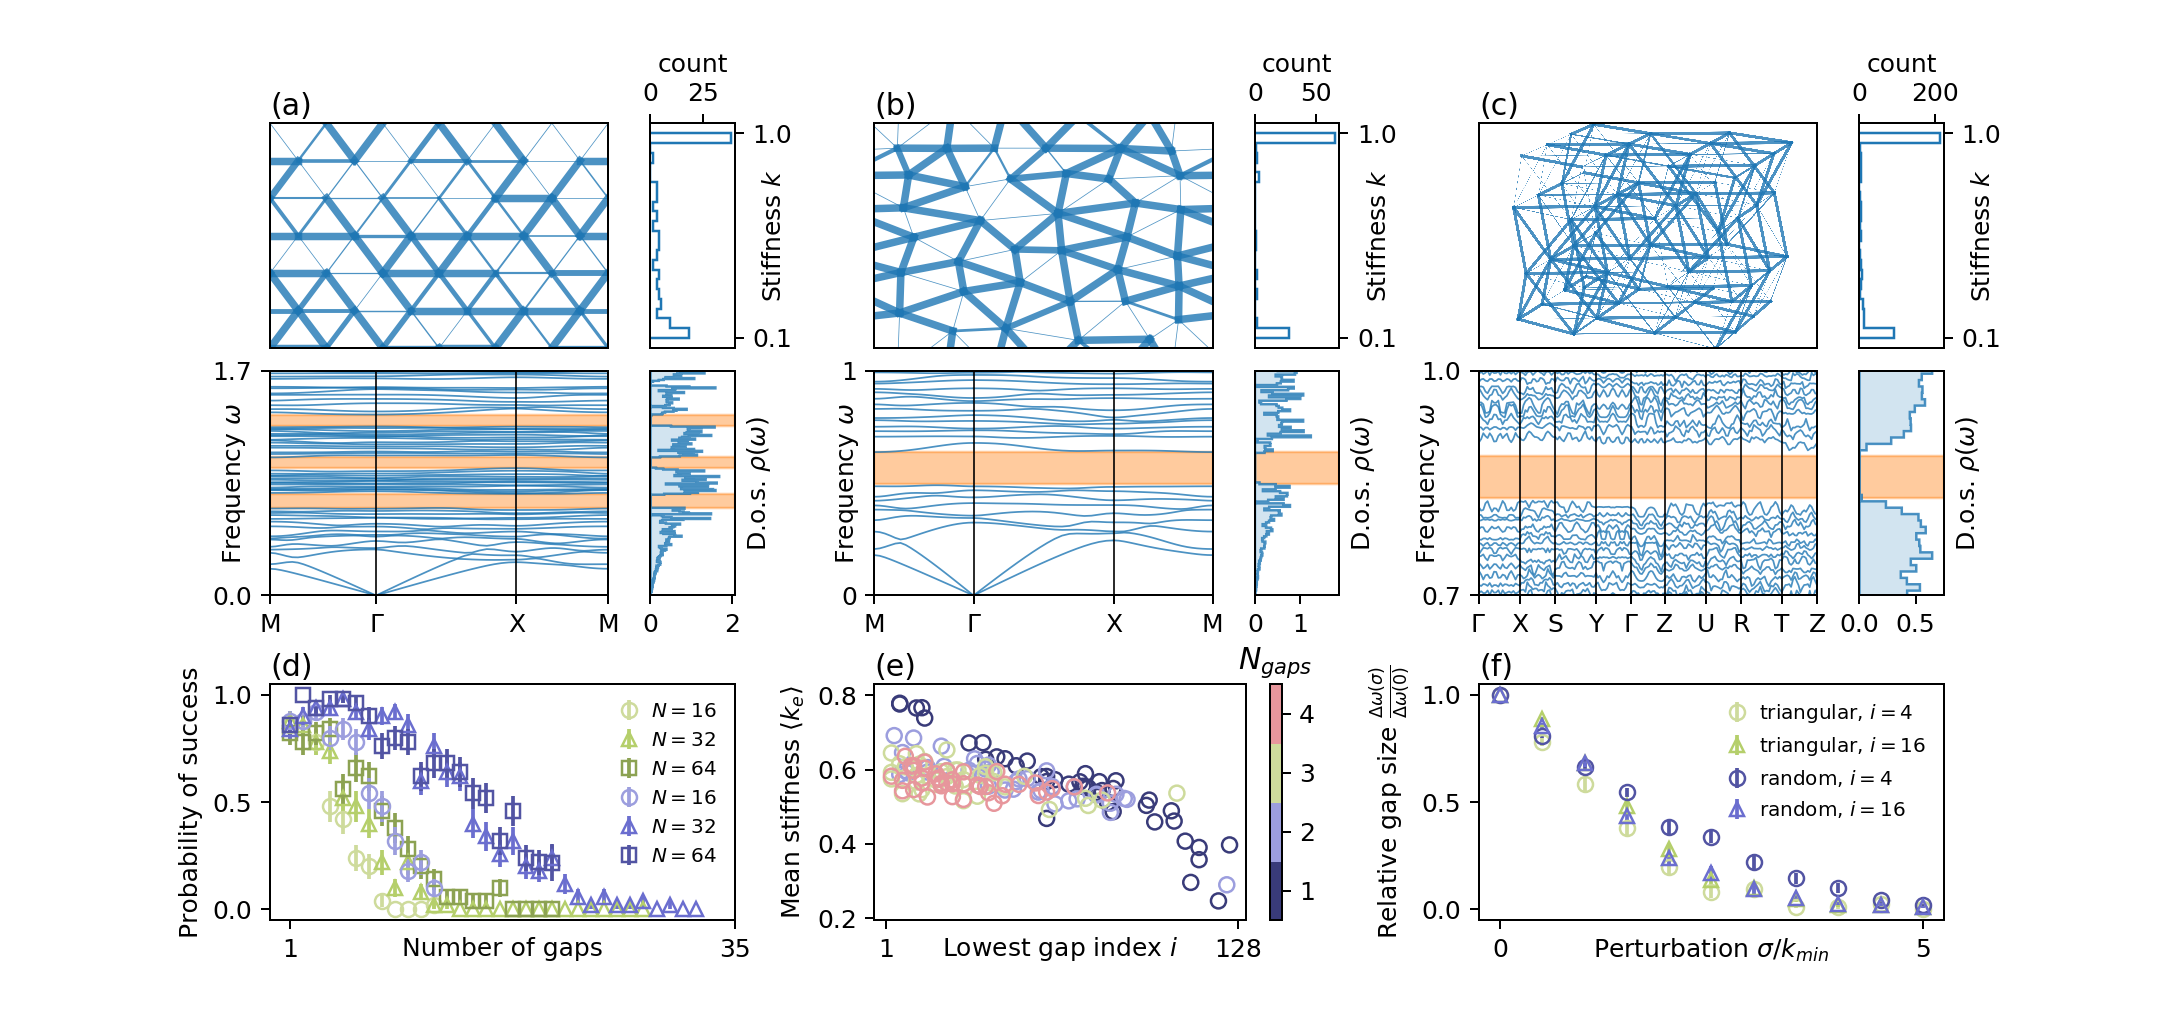

<IPython.core.display.Javascript object>


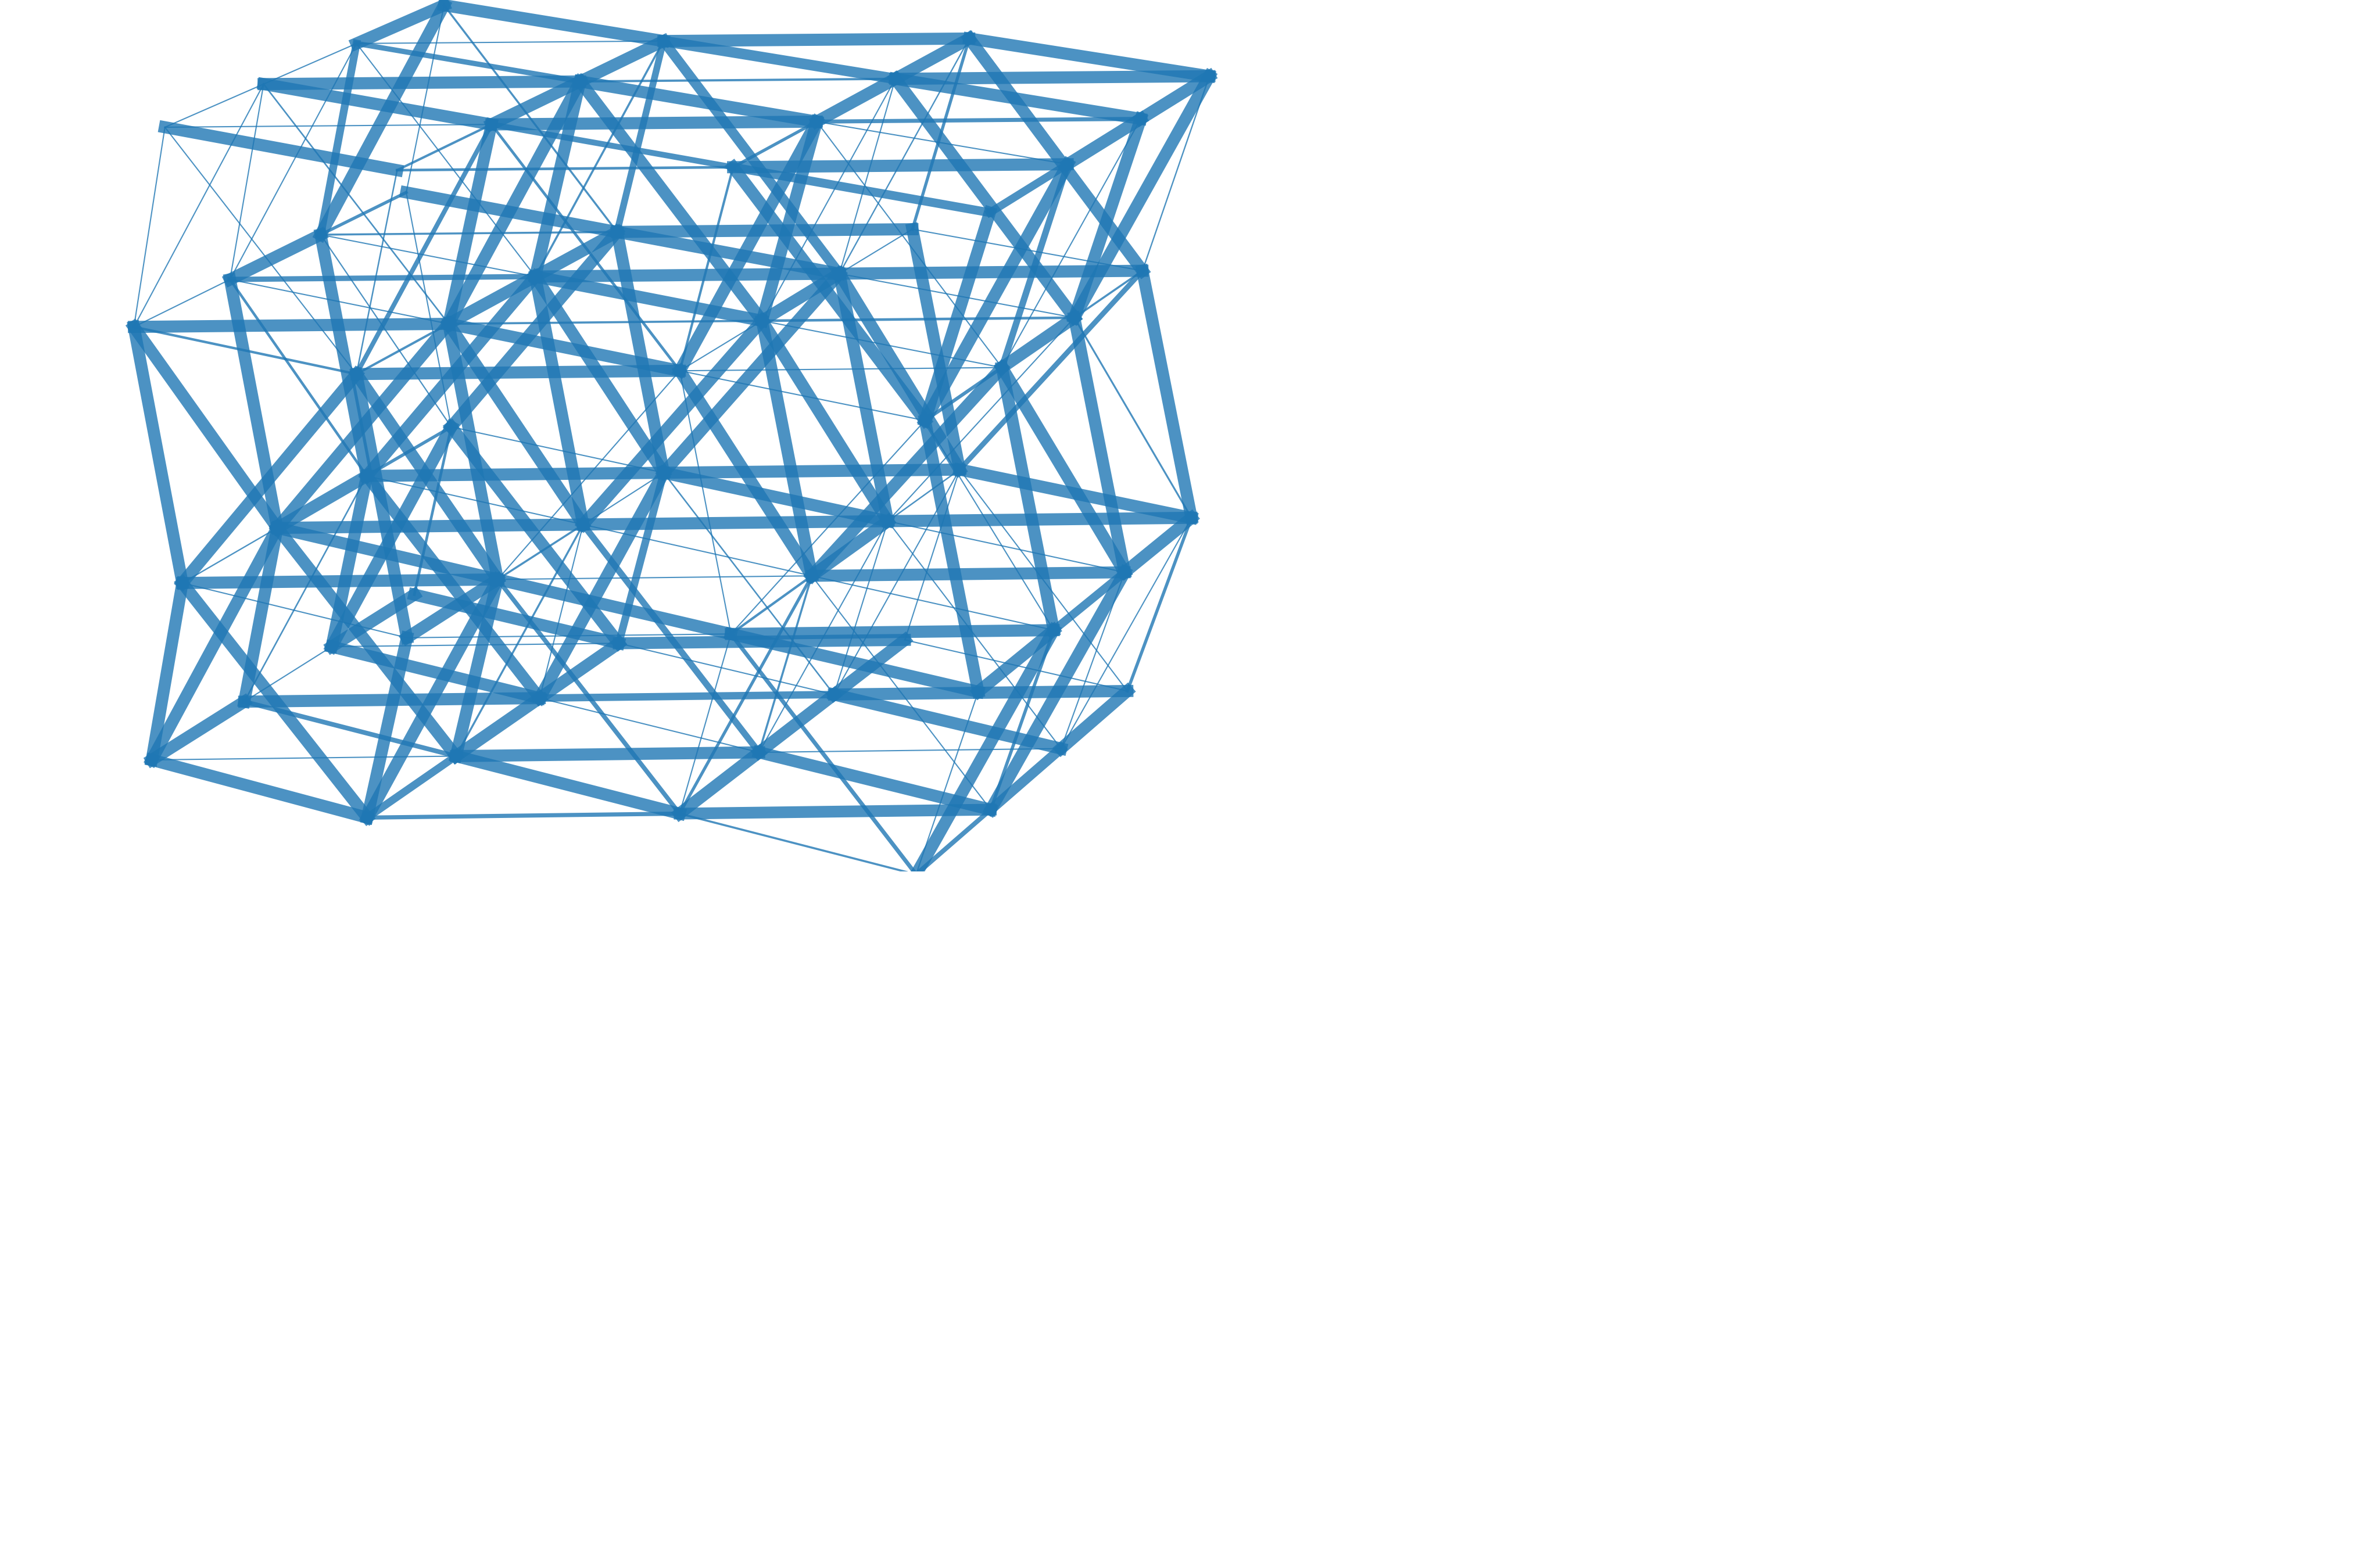

In [17]:
f = plt.figure(figsize=(12, 5.75))

gs = gridspec.GridSpec(2, 3, height_ratios=[2, 1],
                      hspace=0.25, wspace=0.3)


# 3 Gaps triangular grid
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, 
                                       wspace=0.2,
                                       hspace=0.1,
                                       width_ratios=[4,1],
                                       subplot_spec=gs[0,0])
ax_netw = plt.subplot(gs0[0,0])
ax_stiff = plt.subplot(gs0[0,1])
ax_bands = plt.subplot(gs0[1,0])
ax_dos = plt.subplot(gs0[1,1])

plot_result_2d(triang_3gap, ret_triang_3gap[0].x, ax_netw, ax_stiff, ax_bands, ax_dos, 
               show_gaps=opt_triang_3gap.gap_inds, dos_bins=301)

ax_dos.set_yticks([])

ax_bands.set_ylim([0, 1.7])
ax_bands.set_yticks([0, 1.7])
ax_bands.set_ylabel('Frequency $\omega$', labelpad=-14)
ax_dos.set_ylim([0, 1.7])

ax_netw.set_title('(a)', loc='left', y=0.97)


# Delaunay network
a, b = delaunay.graph['periods']

Γ = np.array([0, 0])
M = np.array([0, np.pi/b])
X = np.array([np.pi/a, np.pi/b])

gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, 
                                       wspace=0.2,
                                      hspace=0.1,
                                       width_ratios=[4,1],
                                       subplot_spec=gs[0,1])
ax_netw = plt.subplot(gs0[0,0])
ax_stiff = plt.subplot(gs0[0,1])
ax_bands = plt.subplot(gs0[1,0])
ax_dos = plt.subplot(gs0[1,1])

plot_result_2d(delaunay, ret_delaunay[0].x, ax_netw, ax_stiff, ax_bands, ax_dos,
              show_gaps=opt_delaunay.gap_inds, dos_bins=301)

ax_dos.set_yticks([])

ax_netw.set_title('(b)', loc='left', y=0.97)

ax_bands.set_ylim([0, 1.])
ax_bands.set_yticks([0, 1])
ax_bands.set_ylabel('Frequency $\omega$')

ax_dos.set_ylim([0, 1.])


# 3D network
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, 
                                       wspace=0.2, hspace=0.1,
                                       width_ratios=[4,1],
                                       subplot_spec=gs[0,2])
ax_netw = plt.subplot(gs0[0,0])
ax_stiff = plt.subplot(gs0[0,1])
ax_bands = plt.subplot(gs0[1,0])
ax_dos = plt.subplot(gs0[1,1])

plot_result_3d(triang3d, ret_3d[0], ax_netw, ax_stiff, ax_bands, ax_dos,
               show_gaps=opt_3d.gap_inds, dos_bins=301, n_samples=21,
              figsize=(3*2.5, 2*2.5))

ax_dos.set_yticks([])

ax_bands.set_ylim([0.7, 1.])
ax_bands.set_yticks([0.7, 1])
ax_bands.set_ylabel('Frequency $\omega$')
ax_dos.set_ylim([0.7, 1.])

ax_netw.set_title('(c)', loc='left', y=0.97)


# Data
# gs_data = gridspec.GridSpecFromSubplotSpec(1, 3, 
#                                        width_ratios=[1,1,1],
#                                        subplot_spec=gs[1,:],
#                                           wspace=0.4)

# gs_data = gs[1,:]

shadings = [plt.get_cmap('tab20b')(i/(20)) for i in range(21)]

# P_SAT
ax = plt.subplot(gs[1,0])
ax.errorbar(P_sat_triang_4.index, P_sat_triang_4["success"], yerr=P_sat_std_triang_4["success"], 
            label="$N=16$",
           fmt="o", markerfacecolor='none', color=shadings[7])
ax.errorbar(P_sat_triang_6.index, P_sat_triang_6["success"], yerr=P_sat_std_triang_6["success"], 
            label="$N=32$",
           fmt="^", markerfacecolor='none',color=shadings[6])
ax.errorbar(P_sat_triang_8.index, P_sat_triang_8["success"], yerr=P_sat_std_triang_8["success"], 
            label="$N=64$",
           fmt="s", markerfacecolor='none', color=shadings[5])

ax.errorbar(P_sat_dela_4.index, P_sat_dela_4["success"], yerr=P_sat_std_dela_4["success"], 
            label="$N=16$",
           fmt="o", markerfacecolor='none', color=shadings[3])
ax.errorbar(P_sat_dela_6.index, P_sat_dela_6["success"], yerr=P_sat_std_dela_6["success"], 
            label="$N=32$",
           fmt="^", markerfacecolor='none', color=shadings[2])
ax.errorbar(P_sat_dela_8.index, P_sat_dela_8["success"], yerr=P_sat_std_dela_8["success"], 
            label="$N=64$",
           fmt="s", markerfacecolor='none', color=shadings[1])

ax.set_xlabel("Number of gaps", labelpad=-10)
ax.set_ylabel("Probability of success")
ax.set_title('(d)', loc='left', y=0.97)
# ax.set_ylim(0, 1.5)
ax.set_yticks([0, 0.5, 1.0])
ax.set_xticks([1, 35])
ax.legend(frameon=False, handletextpad=0.1, fontsize=8)


# Stiffnesses for multiple gaps
df_triang_8_4 = df_triang_8.query("n_gaps < 5 and success == True")

ax = plt.subplot(gs[1,1])

# create new cmap
cmap = plt.get_cmap('tab20b')
colors = cmap(np.array([0, 3/20, 7/20, 15/20]))
# Create a new colormap from those colors
color_map = LinearSegmentedColormap.from_list('cut_jet', colors, N=4)

sc = ax.scatter(df_triang_8_4.lowest_gap*128, df_triang_8_4.x_mean, 
                c=df_triang_8_4.n_gaps, cmap=color_map, vmin=0.5, vmax=4.5)

sc.set_facecolor('none')

cb = f.colorbar(sc, ax=ax)
cb.set_ticks([1, 2, 3, 4])
cb.ax.set_title('$N_{gaps}$')

ax.set_xticks([1, 128])

ax.set_xlabel('Lowest gap index $i$', labelpad=-10.5)
ax.set_ylabel(r'Mean stiffness $\langle k_e \rangle$')
ax.set_title('(e)', loc='left', y=0.97)


# Gap robustness
ax = plt.subplot(gs[1,2])
ax.errorbar(sigmas/0.1, pert_4_triang/pert_4_triang[0], yerr=np.array(pert_4_triang_std)/pert_4_triang[0], 
            fmt='o', label="triangular, $i=4$", markerfacecolor='none', color=shadings[7])
ax.errorbar(sigmas/0.1, pert_16_triang/pert_16_triang[0], yerr=np.array(pert_16_triang_std)/pert_16_triang[0], 
          fmt='^', label="triangular, $i=16$", markerfacecolor='none', color=shadings[6])

ax.errorbar(sigmas/0.1, pert_4_del/pert_4_del[0], fmt='o', yerr=np.array(pert_4_del_std)/pert_4_del[0], 
            label="random, $i=4$", markerfacecolor='none', color=shadings[1])
ax.errorbar(sigmas/0.1, pert_16_del/pert_16_del[0], fmt='^', yerr=np.array(pert_16_del_std)/pert_16_del[0], 
          label="random, $i=16$", markerfacecolor='none', color=shadings[2])


ax.set_xticks([0, 5])
# ax.set_xlim([0, 0.5])

ax.set_title('(f)', loc='left', y=0.97)
ax.set_xlabel('Perturbation $\sigma/k_{min}$', labelpad=-10)
ax.set_ylabel(r"Relative gap size $\frac{\Delta\omega(\sigma)}{\Delta\omega(0)}$")
ax.legend(frameon=False, handletextpad=0.1, fontsize=8)

# f.tight_layout()

f.savefig('figures/revtex/fig_1.pdf', dpi=300, bbox_inches='tight')
f.savefig('figures/revtex/fig_1.svg', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


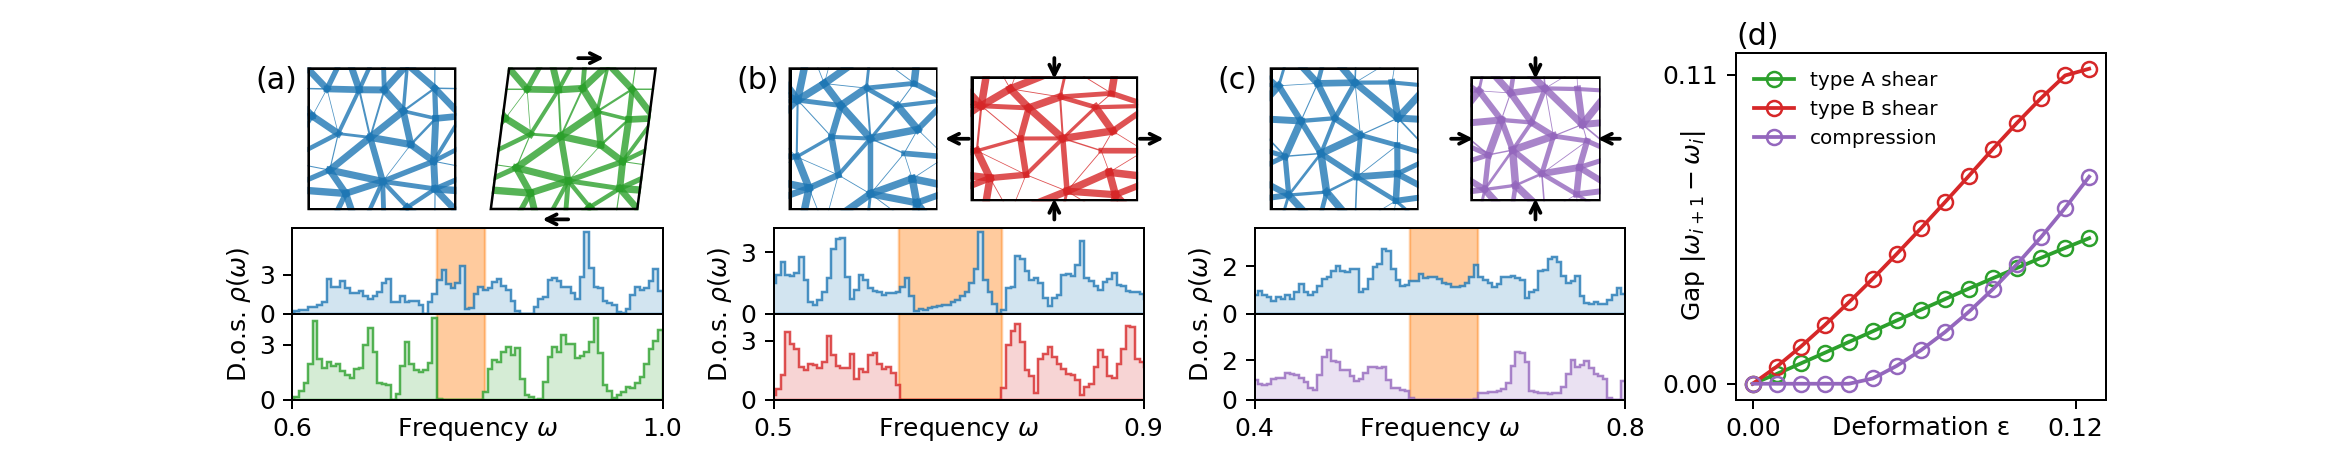

In [33]:
f = plt.figure(figsize=(13, 2.5))

gs = gridspec.GridSpec(1, 4,
                      hspace=0.3, wspace=0.3)
    
def draw_deformed_unit_cell(netw_deformed, k, Γ, ax, shift=(1/8, 1/8), color=blue_alpha, adjust_limits=True,
                           size=None):
    netw_deformed.draw_edges_2d(3*k, ax, color=color)
    
    a, b = netw_deformed.graph['periods']

    unit_cell = np.array([[0, 0], [a, 0], [a, b], [0, b]])
    unit_cell_def = Γ.dot(unit_cell.T).T
    

    poly = Polygon(unit_cell_def, 
                   facecolor='none', edgecolor='k', linewidth=2, zorder=100)
    poly_bg = Polygon(unit_cell_def, 
                      facecolor='w', edgecolor='none', zorder=-100)

    ax.add_patch(poly)
    ax.add_patch(poly_bg)

    for c in ax.get_children():
        c.set_clip_path(poly)

    ax.axis('off')
    
    if adjust_limits:
        # adjust limits such that the unit cell is scaled correctly
        uc_min = unit_cell.min(axis=0)
        uc_max = unit_cell.max(axis=0)

        ucd_min = unit_cell_def.min(axis=0)
        ucd_max = unit_cell_def.max(axis=0)

        x_min = np.min([uc_min[0], ucd_min[0]])
        x_max = np.max([uc_max[0], ucd_max[0]])
        y_min = np.min([uc_min[1], ucd_min[1]])
        y_max = np.max([uc_max[1], ucd_max[1]])

        # make sure that axes are equal and that network is centered
        dx = x_max - x_min
        dy = y_max - y_min
        
        if size is None:
            size = max(dx, dy)

        lx = 0.5*(ucd_min[0] + ucd_max[0] - size)
        ux = lx + size
        
        ly = 0.5*(ucd_min[1] + ucd_max[1] - size)
        uy = ly + size
        
        ax.set_xlim(lx, ux)
        ax.set_ylim(ly, uy)

        return size
    
def annotate_A_shear(ax):
    ax.annotate("", xytext=(0.5, 0.97), xy=(0.7, 0.97), xycoords="axes fraction",
               arrowprops={'arrowstyle': '->', 'lw': 1.5})
    
    ax.annotate("", xytext=(0.3, 0.03), xy=(0.5, 0.03), xycoords="axes fraction",
               arrowprops={'arrowstyle': '<-', 'lw': 1.5})
    
def annotate_B_shear(ax):
    ax.annotate("", xytext=(0.5, 1.0), xy=(0.5, 0.82), xycoords="axes fraction",
               arrowprops={'arrowstyle': '->', 'lw': 1.5})
    
    ax.annotate("", xytext=(0.5, 0.), xy=(0.5, 0.18), xycoords="axes fraction",
               arrowprops={'arrowstyle': '->', 'lw': 1.5})
    
    ax.annotate("", xytext=(0.95, 0.5), xy=(1.14, 0.5), xycoords="axes fraction",
               arrowprops={'arrowstyle': '->', 'lw': 1.5})
    
    ax.annotate("", xytext=(0.05, 0.5), xy=(-0.14, 0.5), xycoords="axes fraction",
               arrowprops={'arrowstyle': '->', 'lw': 1.5})
    
def annotate_compression(ax):
    ax.annotate("", xytext=(0.5, 1.0), xy=(0.5, 0.82), xycoords="axes fraction",
               arrowprops={'arrowstyle': '->', 'lw': 1.5})
    
    ax.annotate("", xytext=(0.5, 0.), xy=(0.5, 0.18), xycoords="axes fraction",
               arrowprops={'arrowstyle': '->', 'lw': 1.5})
    
    ax.annotate("", xytext=(0.82, 0.5), xy=(1.0, 0.5), xycoords="axes fraction",
               arrowprops={'arrowstyle': '<-', 'lw': 1.5})
    
    ax.annotate("", xytext=(0, 0.5), xy=(0.18, 0.5), xycoords="axes fraction",
               arrowprops={'arrowstyle': '->', 'lw': 1.5})    
    
def plot_def_networks(gs, netw, netw_deformed, k, Γ_mat, filldos=None,
                      dos_bins=201, dosrange=(0, 1),
                     dos_yticks=[0, 2], color_deformed=(cycle[1][0], cycle[1][1], cycle[1][2], 0.8)):
    
    gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, 
                                       width_ratios=[1,1],
                                        height_ratios=[1,1],
                                       subplot_spec=gs,
                                          wspace=0.07,
                                          hspace=0.02)
    Id = np.eye(Γ_mat.shape[0])
    

    deformed_muchalpha = flatten_alpha((color_deformed[0], color_deformed[1], color_deformed[2], 0.2))
    blue_muchalpha = flatten_alpha((cycle[0][0], cycle[0][1], cycle[0][2], 0.2))
    

    
    ### Deformed network
    ax_def = plt.subplot(gs0[0,1])
    size = draw_deformed_unit_cell(netw_deformed, k, Γ_mat, ax_def, 
                                            color=color_deformed, adjust_limits=True, size=1.2)

    ### Undeformed network
    ax_undef = plt.subplot(gs0[0,0])
    draw_deformed_unit_cell(netw, k, Id, ax_undef, adjust_limits=True, size=1.2)
    
    ### DOSs
    gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, 
                                       height_ratios=[1,1],
                                       subplot_spec=gs0[1,:],
                                          wspace=0., hspace=0)
    ### DOS undeformed
    ax_dos_undef = plt.subplot(gs1[0,0])
    bz_spec = sample_bz_spectrum_2d(netw, k, sample_type='normal', n_samples=51)
    ax_dos_undef.hist(bz_spec, bins=dos_bins, density=True, histtype='stepfilled', range=(0, 1),
                     color=blue_muchalpha, edgecolor=blue_alpha)
#     ax_dos_undef.set_ylabel('ρ(ω)')
    ax_dos_undef.set_xlim(dosrange[0], dosrange[1])
    ax_dos_undef.set_xticks([])
    ax_dos_undef.set_yticks(dos_yticks)
    
    ### DOS deformed
    ax_dos_def = plt.subplot(gs1[1,0])
    bz_spec = sample_bz_spectrum_2d(netw_deformed, k, sample_type='deformed', n_samples=51)
    ax_dos_def.hist(bz_spec, bins=dos_bins, density=True, histtype='stepfilled', range=(0, 1),
                   color=deformed_muchalpha, edgecolor=color_deformed)
    ax_dos_def.set_xlim(dosrange[0], dosrange[1])
    
    ax_dos_def.set_xticks([dosrange[0], dosrange[1]])
    ax_dos_def.set_yticks(dos_yticks)
    
    ax_dos_def.set_xlabel(r'Frequency $\omega$', labelpad=-10)
    
    # common y label for both DOS plots
    yl = ax_dos_def.set_ylabel(r'D.o.s. $\rho(\omega)$', labelpad=8)
    # position at top of lower axis
    yl.set_position((yl.get_position()[0], 1))
    yl.set_verticalalignment('center')
    
    if filldos is not None:
        # fix limits
        ax_dos_def.set_ylim(*ax_dos_def.get_ylim())
        ax_dos_undef.set_ylim(*ax_dos_undef.set_ylim())
        
        ax_dos_def.fill_betweenx(ax_dos_def.get_ylim(), filldos[0], filldos[1], zorder=-200, 
                                 color=cycle[1], alpha=0.4, edgecolor='none')
        ax_dos_undef.fill_betweenx(ax_dos_undef.get_ylim(), filldos[0], filldos[1], zorder=-200, 
                                 color=cycle[1], alpha=0.4, edgecolor='none')
    
    return ax_undef, ax_def, ax_dos_undef, ax_dos_def
    
alpha_col = lambda x: (cycle[x][0], cycle[x][1], cycle[x][2], 0.8)
    
col = alpha_col(2)
ax, ax_def, ax_dos_undef, ax_dos_def = plot_def_networks(gs[0], netw_shear_1, deformed_shear_1, ret_shear_1.x, Γres_shear_1, 
                       dosrange=(0.6, 1), dos_yticks=[0, 3],
                      filldos=(low_shear_1, up_shear_1), 
                                            color_deformed=col)
ax_dos_undef.set_title('(a)', loc='left', y=2.44, x=-0.1)
annotate_A_shear(ax_def)

col = alpha_col(3)
ax, ax_def, ax_dos_undef, ax_dos_def = plot_def_networks(gs[1], netw_switch_3, deformed_shear_3, ret_switch_3.x, Γres_shear_3, 
                       dosrange=(0.5, 0.9), dos_yticks=[0, 3],
                      filldos=(low_shear_3, up_shear_3),
                                            color_deformed=col)
ax_dos_undef.set_title('(b)', loc='left', y=2.44, x=-0.1)
annotate_B_shear(ax_def)

col = alpha_col(4)
ax, ax_def, ax_dos_undef, ax_dos_def = plot_def_networks(gs[2], netw_switch_4, deformed_compr_4, ret_switch_4.x, Γres_compr_4, 
                       dosrange=(0.4, 0.8), dos_yticks=[0, 2],
                      filldos=(low_compr_4, up_compr_4),
                                            color_deformed=col)

annotate_compression(ax_def)
ax_dos_undef.set_title('(c)', loc='left', y=2.44, x=-0.1)

# Gap size
ax_gs = plt.subplot(gs[3])
ax_gs.plot(ϵs_shear_1, gs_shear_1, "o-", markerfacecolor='none', color=cycle[2],
           label="type A shear")
ax_gs.plot(ϵs_shear_3, gs_shear_3, "o-", markerfacecolor='none', color=cycle[3],
           label="type B shear")
ax_gs.plot(ϵs_compr_4, gs_compr_4, "o-", markerfacecolor='none', color=cycle[4],
           label="compression")


ax_gs.set_xlabel("Deformation ε", labelpad=-10)
ax_gs.set_ylabel(r"Gap $|\omega_{i+1} - \omega_i|$", labelpad=-18)
# ax_gs.axvline(0.2, linestyle=":", alpha=0.5, color='k')
# ax_gs.set_ylim(0, 0.2)
ax_gs.set_yticks([0, 0.11])
ax_gs.set_xticks([0, 0.12])

ax_gs.legend(frameon=False, fontsize=8, loc="upper left")
ax_gs.set_title("(d)", loc="left", y=0.98)

f.savefig('figures/revtex/fig_2.svg', dpi=300, bbox_inches='tight')
f.savefig('figures/revtex/fig_2.pdf', dpi=300, bbox_inches='tight')

# FEM v2

In [19]:
def get_fem_data(fname, i0=3):
    fem_data = np.loadtxt(fname, delimiter=',')
    i0 = 3

    emax = 90

    frequencies = fem_data[:,0]
    in_plane = fem_data[:,2]

    inp = np.logical_or(in_plane > 0.5, np.abs(frequencies) < 1e-1)

    inp_freqs = frequencies[inp][i0:]
    
    return inp_freqs

inp_freqs = 1/(2*np.pi)*get_fem_data('fem_networks/tuned_spring_big.stl.txt')
inp_freqs_rand = 1/(2*np.pi)*get_fem_data('fem_networks/random_spring.stl.txt')

In [20]:
strong_fit = np.loadtxt('fem_networks/strong_springs_fit.txt')
weak_fit = np.loadtxt('fem_networks/weak_springs_fit.txt')

<IPython.core.display.Javascript object>


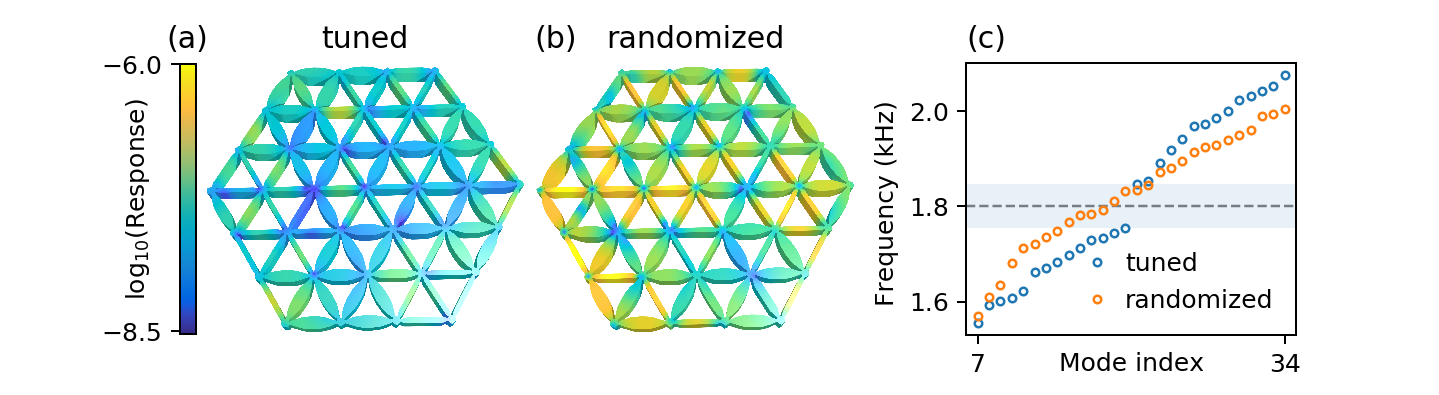

In [37]:
f = plt.figure(figsize=(0.8*10, 0.8*2.75))

gs = gridspec.GridSpec(1, 2, width_ratios=[2.05,1], wspace=0.22)

gs2 = gridspec.GridSpecFromSubplotSpec(1, 3,
                                       gs[0],
                                       width_ratios=[0.05,1,1],
                                      wspace=0.04)

ax_fem_geometry = plt.subplot(gs2[1])
ax_fem_geometry.set_xticks([])
ax_fem_geometry.set_yticks([])
ax_fem_geometry.axis('off')
ax_fem_geometry.imshow(plt.imread("continuum_tuned.png"))
ax_fem_geometry.set_title("(a)", loc="left", x=-0.12)
ax_fem_geometry.set_title("tuned")


ax_fem_mesh = plt.subplot(gs2[2])
ax_fem_mesh.set_xticks([])
ax_fem_mesh.set_yticks([])
ax_fem_mesh.axis('off')
ax_fem_mesh.imshow(plt.imread("continuum_random.png"))
ax_fem_mesh.set_title("(b)", loc='left')
ax_fem_mesh.set_title("randomized")


# ax_spectral_fit = plt.subplot(gs[0])
# ax_spectral_fit.plot(strong_fit[:,1]/1000, 'o', markerfacecolor='none', 
#                      alpha=0.75, label="FEM in-plane (stiff)")
# ax_spectral_fit.plot(strong_fit[:,0]/1000, '.', markerfacecolor='none', 
#                      alpha=0.9, label="network model (stiff)")

# ax_spectral_fit.plot(weak_fit[:,1]/1000, 'o', markerfacecolor='none', 
#                      alpha=0.75, label="FEM in-plane (weak)")
# ax_spectral_fit.plot(weak_fit[:,0]/1000, '.', markerfacecolor='none', 
#                      alpha=0.9, label="network model (weak)")


# ax_spectral_fit.legend(frameon=False, handletextpad=0.1)

# ax_spectral_fit.set_xlabel('mode index')
# ax_spectral_fit.set_ylabel('frequency (kHz)')
# ax_spectral_fit.set_title('(a)', loc='left')

# MATLAB colormap
gs_cb = gridspec.GridSpecFromSubplotSpec(3, 1, gs2[0], height_ratios=[0, 100, 0])
ax_cmap = plt.subplot(gs_cb[1])

# data from MATLAB FEM
vmax = -6.05
vmin = -8.52
norm = Normalize(vmin=vmin, vmax=-6)
sm = ScalarMappable(norm=norm, cmap='parula')
sm.set_array(np.linspace(vmin, vmax, 100))

cb = f.colorbar(sm, cax=ax_cmap, ticks=[-8.5, -6])
cb.ax.yaxis.set_ticks_position('left')
cb.ax.set_ylabel(r"$\log_{10}(\mathrm{Response})$", labelpad=-29)

ax_spectral_optimization = plt.subplot(gs[1])

ax_spectral_optimization.plot(range(7, 35), inp_freqs[7:35]/1000, '.', 
                              markerfacecolor='none',
                              label='tuned')
ax_spectral_optimization.plot(range(7, 35), inp_freqs_rand[7:35]/1000, '.', 
                              markerfacecolor='none',
                              label='randomized')

ax_spectral_optimization.fill_between(range(6, 36), inp_freqs[20]/1000, inp_freqs[21]/1000, alpha=0.1)

ax_spectral_optimization.axhline(1.8, ls='--', color='k', alpha=0.5, zorder=-100, lw=1)
# ax_spectral_optimization.set_ylim(1.6, 2.0)
ax_spectral_optimization.set_yticks([1.6, 1.8, 2.0])

ax_spectral_optimization.set_xlabel('Mode index', labelpad=-10)
ax_spectral_optimization.set_ylabel('Frequency (kHz) ')
ax_spectral_optimization.set_title('(c)', loc='left')
ax_spectral_optimization.set_xticks([7,  34])
ax_spectral_optimization.set_xlim([6, 35])
ax_spectral_optimization.legend(frameon=False, handletextpad=0.1)

ax_spectral_optimization.set_aspect(42)

# gs.tight_layout(f)

f.savefig('figures/revtex/fig_3.pdf', dpi=300, bbox_inches='tight')
f.savefig('figures/revtex/fig_3.svg', dpi=300, bbox_inches='tight')

# Figure 4 -- Topological modes

In [22]:
def sigma2_matrix(netw, q=None):
    σ_2 = sp.sparse.bmat([[None, -1j*sp.sparse.eye(netw.number_of_nodes())],
                     [1j*sp.sparse.eye(netw.number_of_nodes()), None]])
    
    # Fouier transform
    if q is not None:
        dot_prods = np.dot(netw.graph['x'], q)
        phases = sp.sparse.diags(np.tile(np.exp(-1j*dot_prods), 2))        
        σ_2 = phases.dot(σ_2).dot(phases.conj())

    return σ_2

def plot_band_structure_lubensky(network, k, a, b, Ω, ax, samples=20, draw_gap=True, fc='none', bandcol='k', draw_dos=True):
    """ Plot the band structure of the 2D periodic network
    with periods a and b.
    """
    Gamma = np.array([0., 0.])
    M = np.array([np.pi/a, np.pi/b])
    X = np.array([np.pi/a, 0])
    
    Q = network.graph['Q']
    K = sp.sparse.diags(k)
    
    sqrtK = sp.sparse.diags(np.sqrt(k))
    
#     σ_2 = sp.sparse.bmat([[None, -1j*sp.sparse.eye(network.number_of_nodes())],
#                          [1j*sp.sparse.eye(network.number_of_nodes()), None]])
        
    
    def get_spectrum_at(k, q):
        K = sp.sparse.diags(k)
        sqrtK = sp.sparse.diags(np.sqrt(k))

#         Q_q = networks.fourier_transform_Q(network, Q, q)
#         K_q = Q_q.dot(K).dot(Q_q.conj().transpose()).toarray()
#         u = sp.linalg.eigvalsh(K_q, turbo=True)
        
        Q_q = networks.fourier_transform_Q(network, Q, q)

        Q_sqrtK = Q_q.dot(sqrtK)
        σ_2 = sigma2_matrix(network, q)
#             U, S, Vh = sp.linalg.svd(Q_sqrtK)

#             # construct eigenstate of the "quantum" Hamiltonian
#             n_k = np.concatenate((U[:,n], Vh[n,:].conj()))

        H = sp.sparse.bmat([[2*Ω*σ_2, Q_sqrtK],
                           [Q_sqrtK.transpose().conj(), None]]).toarray()
    
#         H = sp.sparse.bmat([[None, sp.sparse.eye(2*network.number_of_nodes())],
#                            [-Q_sqrtK.dot(Q_sqrtK.transpose().conj()), -2j*Ω*σ_2]]).toarray()

        u = sp.linalg.eigvalsh(H, turbo=True)
#         u = np.abs(sp.linalg.eigvals(H))
#         u.sort()
        
#         print(v)
        
        return u
    
    def sample_direction(x, y):
        ts = np.linspace(0, 1, samples)
        spectra = []
        
        for t in ts:
            q = x + t*(y-x)
            u = get_spectrum_at(k, q)
            spectra.append(u)
            
        ts *= np.linalg.norm(x - y)
        return ts, spectra
    
    def sample_dos(k):
        xs = np.linspace(-np.pi/a, np.pi/a, int(samples/2)+1)
        ys = np.linspace(-np.pi/b, np.pi/b, int(samples/2)+1)
        
        states = []
        for x in xs:
            for y in ys:
                q = np.array([x, y])
                u = get_spectrum_at(k, q)
                states.extend(u)
                
        return np.array(states)
    
    def draw_the_gap(i0, specs):
        # find gap position
        i1 = i0 + 1
        lower = np.max([sp[i0] for sp in specs])
        upper = np.min([sp[i1] for sp in specs])
        
        xx0, xx1 = ax.get_xlim()
        ax.fill_between(np.linspace(xx0, xx1), lower, upper, 
                             color='y', edgecolor=None, alpha=0.6, linewidth=0)
        ax.set_xlim(xx0, xx1)
        
        return lower, upper
    
    ts_1, spec_1 = sample_direction(M, Gamma)
    ts_2, spec_2 = sample_direction(Gamma, X)
    ts_3, spec_3 = sample_direction(X, M)
    
    ts_2 += ts_1[-1]
    ts_3 += ts_2[-1]
        
    ax.plot(ts_1, spec_1, color=bandcol, lw=0.3)
    ax.plot(ts_2, spec_2, color=bandcol, lw=0.3)
    ax.plot(ts_3, spec_3, color=bandcol, lw=0.3)

    ax.axvline(ts_1[-1], color='k', lw=0.75)
    ax.axvline(ts_2[-1], color='k', lw=0.75)
    
    ax.set_xticks([0, ts_1[-1], ts_2[-1], ts_3[-1]])
    ax.set_xticklabels([r'M', r'$\Gamma$', r'X', r'M'])
        
    ax.autoscale(tight=True)
    
    if draw_gap:
        lower, upper = draw_the_gap(Q.shape[1] + opt.gap_inds[0], spec_1 + spec_2 + spec_3)
    else:
        lower, upper = 0, 0
    
    ax.set_ylabel(r'Frequency $\omega$')
    
    # divide and plot density of states
    if draw_dos:
        states = sample_dos(k)
        states = states[states > 1e-8] # don't plot all those zero modes

        divider = make_axes_locatable(ax)
        ax_dos = divider.append_axes("right", size=0.6, pad=0.15)

        dos_range = (np.min(states), np.max(states))   

        ax_dos.hist(states, orientation='horizontal', bins=200, histtype='stepfilled', normed=True, range=dos_range)

        ax_dos.set_ylabel(r'Density of states $\rho(\omega)$', labelpad=3)
        ax_dos.yaxis.set_ticks_position('right')
        ax_dos.yaxis.set_label_position('right')

        for tl in ax_dos.get_yticklabels():
            tl.set_visible(False)

    #     for tl in ax_dos.get_xticklabels():
    #         tl.set_horizontalalignment('left')

        _, y1 = ax.get_ylim()
        ax.set_ylim(0, y1*1.03)
        ax_dos.set_ylim(0, y1*1.03)
    else:
        ax_dos = None
    
    return ax_dos, lower, upper

def plot_band_structure_1d_lubensky(network, k, a, Ω, ax, samples=20, draw_gap=True, fc='none', bandcol='k',
                          number_bands=False, plot_localization=False, direction='x'):
    """ Plot the band structure of the 2D periodic network
    with periods a and b.
    """
    if direction == 'x':
        Left = np.array([-np.pi/a, 0])
        Right = np.array([np.pi/a, 0])
    else:
        Left = np.array([0, -np.pi/a])
        Right = np.array([0, np.pi/a])
    
    Q = network.graph['Q']
    K = sp.sparse.diags(k)
    sqrtK = sp.sparse.diags(np.sqrt(k))

    def get_spectrum_at(k, q, localization=False):
        K = sp.sparse.diags(k)
        sqrtK = sp.sparse.diags(np.sqrt(k))
        
        Q_q = networks.fourier_transform_Q(network, Q, q)
        σ_2 = sigma2_matrix(network, q)

        Q_sqrtK = Q_q.dot(sqrtK)
        H = sp.sparse.bmat([[2*Ω*σ_2, Q_sqrtK],
                           [Q_sqrtK.transpose().conj(), None]]).toarray()
    
        u, v = sp.linalg.eigh(H, turbo=True)

        
        if localization:
            loc = np.sum(np.abs(v)**4, axis=0)
            return u, loc
        else:
            return u
    
    def sample_direction(x, y, localization=False):
        ts = np.linspace(0, 1, samples)
        spectra = []
        locs = []
        
        for t in ts:
            q = x + t*(y-x)
            u = get_spectrum_at(k, q, localization)
            
            if localization:
                u, loc = u
                locs.append(loc)
            
            spectra.append(u)
            
        ts *= np.linalg.norm(x - y)
        
        if localization:
            return ts, spectra, locs
        else:
            return ts, spectra
    
    def sample_dos(k):
        xs = np.linspace(-np.pi/a, np.pi/a, 2*samples + 1)
        
        states = []
        for x in xs:
            q = np.array([x, 0])
            u = get_spectrum_at(k, q)
            states.extend(u)
                
        return states
    
    def draw_the_gap(i0, specs):
        # find gap position
        i1 = i0 + 1
        lower = np.max([sp[i0] for sp in specs])
        upper = np.min([sp[i1] for sp in specs])
        
        xx0, xx1 = ax.get_xlim()
        ax.fill_between(np.linspace(xx0, xx1), lower, upper, 
                             color='y', edgecolor=None, alpha=0.6, linewidth=0)
        ax.set_xlim(xx0, xx1)
        
        return lower, upper
    
    # plot the bands
    if plot_localization:
        ts_1, spec_1, loc = sample_direction(Left, Right, localization=plot_localization)
        
        spec_1 = np.array(spec_1)
        loc = np.array(loc)
        
        cmin, cmax = np.min(np.log10(loc)), np.max(np.log10(loc))
        for band, band_loc in zip(spec_1.T, loc.T):
            c_line = plot_colored_line(ax, ts_1 - np.pi/a, band, np.log10(band_loc), cmin=cmin, cmax=cmax,
                             lw=2)
    else:
        ts_1, spec_1 = sample_direction(Left, Right, localization=plot_localization)

        ax.plot(ts_1-np.pi/a, spec_1, color=bandcol, lw=0.3)

    
#     ax.set_xticks([-np.pi/a, 0, np.pi/a])
#     ax.set_xticklabels(["-π/a", "0", "π/a"])
        
    ax.autoscale(tight=True)
    
    if draw_gap:
        draw_the_gap(opt.gap_inds[0], spec_1)
 
    
    ax.set_ylabel(r'Frequency $\omega$')
    
    if number_bands:
        i = int(samples/2)
        for j, s in enumerate(spec_1[i]):
            ax.text(0, s, str(j))
    
    # divide and plot density of states
#     states = sample_dos(k)
    
#     divider = make_axes_locatable(ax)
#     ax_dos = divider.append_axes("right", size=0.6, pad=0.15)
    
#     dos_range = (np.min(states), np.max(states))   
    
#     ax_dos.hist(states, orientation='horizontal', bins=100, histtype='stepfilled', normed=True, range=dos_range)
    
#     ax_dos.set_ylabel(r'Density of states $\rho(\omega)$')
#     ax_dos.yaxis.set_ticks_position('right')
#     ax_dos.yaxis.set_label_position('right')
    
#     for tl in ax_dos.get_yticklabels():
#         tl.set_visible(False)
        
# #     for tl in ax_dos.get_xticklabels():
# #         tl.set_horizontalalignment('left')
    
#     _, y1 = ax.get_ylim()
#     ax.set_ylim(0, y1*1.03)
#     ax_dos.set_ylim(0, y1*1.03)
    
    ax_dos = None
    if plot_localization:
#         ax_cb = divider.append_axes("top", size=0.1, pad=0.5)
        return ax_dos, c_line, spec_1, loc
    
    return ax_dos

def get_modes_at(netw, k, q, Ω):
    K = sp.sparse.diags(k)
    
    sqrtK = sp.sparse.diags(np.sqrt(k))
    
    σ_2 = sigma2_matrix(netw, q)
    
    Q = netw.graph['Q']
    Q_q = networks.fourier_transform_Q(netw, Q, q)

    Q_sqrtK = Q_q.dot(sqrtK)
    H = sp.sparse.bmat([[2*Ω*σ_2, Q_sqrtK],
                       [Q_sqrtK.transpose().conj(), None]]).toarray()

    u, v = sp.linalg.eigh(H, turbo=True)
    
    return u, v[:σ_2.shape[0],:]

def get_modes_at_real(netw, k, q):
    K = sp.sparse.diags(k)
        
#     σ_2 = sigma2_matrix(netw, q=None)
    
    Q = netw.graph['Q']
    Q_q = networks.fourier_transform_Q(netw, Q, q)

    H = Q_q.dot(K).dot(Q_q.conj().transpose())

    u, v = sp.linalg.eigh(H.toarray(), turbo=True)
    
    return u, v

def draw_mode_loc(netw, v, ax):
    pos = netw.graph['pos']
    x = np.array([pos[n] for n in netw.graph['nodelist']])
    
    ax.scatter(x[:,0], x[:,1], s=100*v, c=sns.color_palette()[0], zorder=100, alpha=1.0)
    
    
def sample_dos(netw, k, Ω, samples):
    a, b = netw.graph['periods']
    
    xs = np.linspace(-np.pi/a, np.pi/a, int(samples/2)+1)
    ys = np.linspace(-np.pi/b, np.pi/b, int(samples/2)+1)

    states = []
    for x in xs:
        for y in ys:
            q = np.array([x, y])
            u, v = get_modes_at(netw, k, q, Ω)
            states.append(u)

    return np.array(states)
    
def all_gaps_at(netw, k, Ω, samples=11):
    """ Return a vector containing all gap sizes at given rotation rate.
    The entrire BZ is sampled with the given sampling.
    """
    states = sample_dos(netw, k, Ω, samples)
    
    min_bands = np.min(states, axis=0)
    max_bands = np.max(states, axis=0)
    
    gap_sizes = min_bands[1:] - max_bands[:-1]
    gap_sizes[gap_sizes < 0] = 0.0
    
    return gap_sizes

def plot_colored_line(ax, x, y, c, cmap='viridis', cmin=None, cmax=None, lw=1.0):
    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(c.min() if cmin is None else cmin, 
                         c.max() if cmax is None else cmax)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    # Set the values used for colormapping
    lc.set_array(c)
    lc.set_linewidth(lw)

    line = ax.add_collection(lc)
        
    return line

In [23]:
triang = networks.TriangularGrid2D(n=4, x_periodic=True, y_periodic=True)
# optimize single gap
a, b = triang.graph['periods']

print(a, b)

Gamma = np.array([0., 0.])
M = np.array([np.pi/a, np.pi/b])
X = np.array([np.pi/a, 0])

opt = response_optimization.PointMassOptimizer(triang, [3], [Gamma, M, X, M-X])

ret, x0 = opt.optimize(lower_bound=0.1)

opt.gap_inds

# k = ret.x
ret.x = np.loadtxt('data_edge_modes/triang_4x4_chern_edge_mode_network_5.txt')
k = ret.x

4.0 3.4641016151377544


In [24]:
# 1D periodic network

ca, cb = 1, 12

new, k_new = triang.tile_unit_cell_2d(k, ca, cb)

# new_np, k_new_np = new.non_periodic_directional(k_new, x_nonp=True, y_nonp=False)
new_np, k_new_np = new.non_periodic_directional(k_new, x_nonp=False, y_nonp=True)

In [25]:
fa, fb = 17, 8

new, k_new = triang.tile_unit_cell_2d(k, fa, fb)
new_np_f, k_new_np_f = new.non_periodic_directional(k_new, x_nonp=True, y_nonp=True)

# remove one line of unit cells
for kk, e in zip(k_new_np_f, new_np_f.graph['edgelist']):
    new_np_f.edges[e[0],e[1]]['k'] = kk
    
nodes_to_rem = []
    
# nodes_to_rem += [n for n in new_np_f if new_np_f.graph['pos'][n][1] <= 3*np.sqrt(3/4) and (16.5 <= new_np_f.graph['pos'][n][0] <= 22)]

# nodes_to_rem += [n for n in new_np_f if new_np_f.graph['pos'][n][1] <= 6*np.sqrt(3/4) and (16.5 <= new_np_f.graph['pos'][n][0] <= 20)]

# nodes_to_rem += [n for n in new_np_f if new_np_f.graph['pos'][n][1] <= 6*np.sqrt(3/4) and (16.5 <= new_np_f.graph['pos'][n][0] <= 20)]

nodes_to_rem += [n for n in new_np_f if new_np_f.graph['pos'][n][0] <= 1/np.sqrt(3)*new_np_f.graph['pos'][n][1]]

nodes_to_rem += [n for n in new_np_f if new_np_f.graph['pos'][n][0] >= 26.5 + 1/np.sqrt(3)*new_np_f.graph['pos'][n][1]]

nodes_to_rem += [n for n in new_np_f if new_np_f.graph['pos'][n][1] >= 21.5]


new_np_f.remove_nodes_from(nodes_to_rem)

new_np_f.init_attrs()
k_new_np_f = np.array([new_np_f.edges[e]['k'] for e in new_np_f.graph['edgelist']])

In [26]:
σ_2 = sigma2_matrix(new_np_f)

K = sp.sparse.diags(k_new_np_f)
Q = new_np_f.graph['Q']
D = Q.dot(K).dot(Q.conj().transpose())

omega = 0.575
Omega = -0.16

Ginv = -omega**2*np.eye(D.shape[0]) + 2*omega*Omega*σ_2.toarray() + D.toarray()

G = np.array(np.linalg.inv(Ginv))

In [27]:
n = new_np_f.number_of_nodes()

G_mean = np.diag(G.dot(G.conj().transpose()))
s = 0
G_mean = (G[s,:] + G[s+n,:])/np.sqrt(2)
6*np.pi/omega



32.7818363852848

<IPython.core.display.Javascript object>


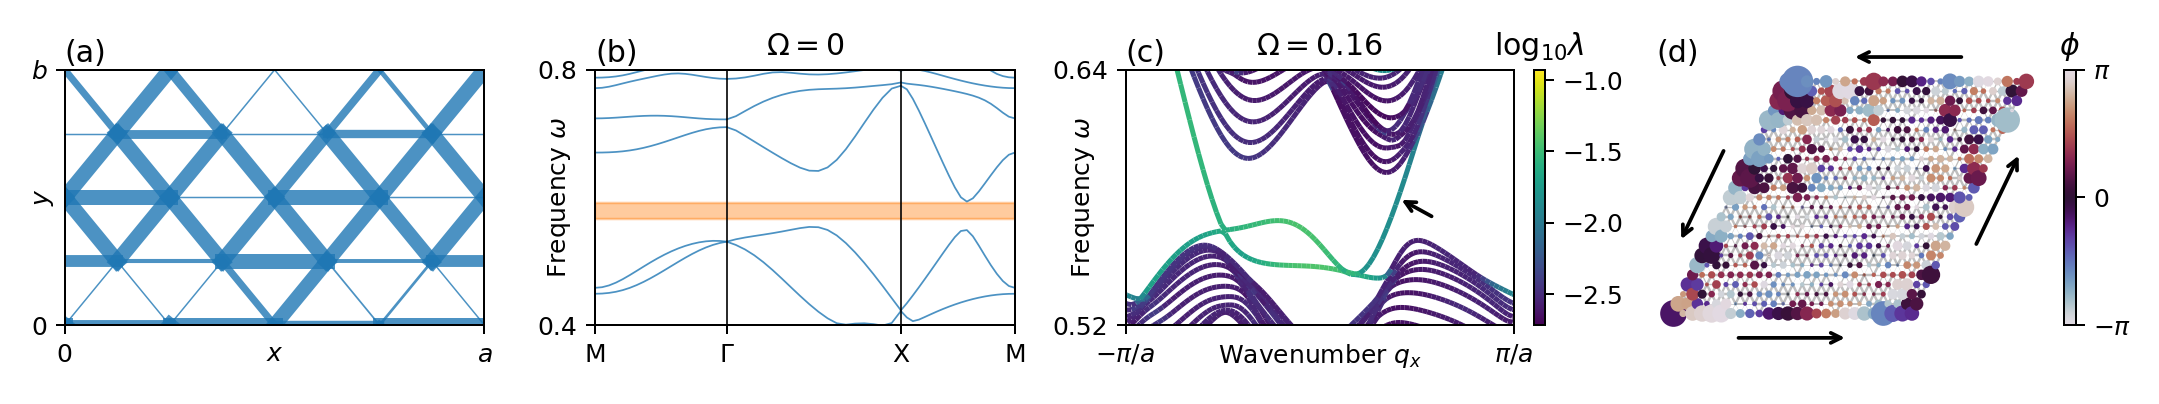

In [36]:
f = plt.figure(figsize=(12, 2.25))

gs = gridspec.GridSpec(1, 4, f, hspace=0.01)

##
## Network and band structure
##
ax_nw = f.add_subplot(gs[0])
ax_bd = f.add_subplot(gs[1])

plot_result_2d(triang, ret.x, ax_nw, None, ax_bd, None,
              show_gaps=opt.gap_inds, factor=2)

# ax_bd.set_ylim(0, 1)
# ax_bd.set_yticks([0, 1])
# ax_bd.set_ylabel('Frequency $\omega$')

ax_nw.set_xticks([0, a])
ax_nw.set_yticks([0, b])

ax_nw.set_xticklabels([0, "$a$"])
ax_nw.set_yticklabels([0, "$b$"])

ax_nw.set_xlabel("$x$", labelpad=-10)
ax_nw.set_ylabel("$y$", labelpad=-10)

ax_bd.set_ylim(0.4, 0.8)
ax_bd.set_yticks([0.4, 0.8])
ax_bd.set_ylabel(r"Frequency $\omega$", labelpad=-14)

ax_nw.set_title("(a)", loc='left', y=0.97)
ax_bd.set_title("(b)", loc='left', y=0.97)
ax_bd.set_title("$\Omega = 0$")

##
## 1D band structure in the topological phase
##

ggs = gridspec.GridSpecFromSubplotSpec(1, 2, gs[2], width_ratios=[1, 0.03], wspace=0.1)

ax_bd_1d = f.add_subplot(ggs[0])


ax_dos, cl, spec, loc = plot_band_structure_1d_lubensky(new_np, k_new_np, 
                                                               b, -0.16, ax_bd_1d, draw_gap=False, 
                                                               samples=101, number_bands=False,
                      plot_localization=True)
ax_bd_1d.set_xlim(-np.pi/a, np.pi/a)
ax_bd_1d.set_xticks([-np.pi/a, np.pi/a])
ax_bd_1d.set_xticklabels([r"$-\pi/a$", r"$\pi/a$"])
ax_bd_1d.set_xlabel(r"Wavenumber $q_x$", labelpad=-10)

ax_bd_1d.set_ylim(0.52, 0.64)
ax_bd_1d.set_yticks([0.52, 0.64])
ax_bd_1d.set_ylabel(r"Frequency $\omega$", labelpad=-18)


cax = f.add_subplot(ggs[1])
cb = f.colorbar(cl, cax=cax)
# cb.ax.set_yticklabels(["$-\pi$", "$0$", "$\pi$"])
cb.ax.set_title("$\log_{10}\lambda$")

x = 0.5*np.pi/triang.graph['periods'][0]
ax_bd_1d.annotate("", xytext=(1.2*x, 0.57), xy=(0.8*x, 0.58), xycoords="data",
           arrowprops={'arrowstyle': '->', 'lw': 1.5})


ax_bd_1d.set_title("$\Omega = 0.16$")
ax_bd_1d.set_title("(c)", loc='left', y=0.97)

##
## edge mode in finite network
##

ggs = gridspec.GridSpecFromSubplotSpec(1, 2, gs[3], width_ratios=[1, 0.03], wspace=0.1)
ax_fn = f.add_subplot(ggs[0])

new_np_f.draw_edges_2d(k_new_np_f, ax_fn, alpha=0.25);
X = new_np_f.graph['x']

ax_fn.plot([X[s,0]], [X[s,1]], "ro", zorder=100000)
vv = np.linalg.norm((np.real(G_mean)).reshape(2, n), axis=0)
ac = ax_fn.scatter(X[:,0], X[:,1], s=15*vv**2, c=np.angle(G_mean)[:n], 
                   cmap='twilight', zorder=np.inf, vmin=-np.pi, vmax=np.pi,
                  clip_on=False)

cax = f.add_subplot(ggs[1])
cb = f.colorbar(ac, cax=cax, ticks=[-np.pi, 0, np.pi])
cb.ax.set_yticklabels(["$-\pi$", "$0$", "$\pi$"])
cb.ax.set_title("$\phi$")

# ax_fn.axis("equal")
ax_fn.axis("off")
ax_fn.relim()
ax_fn.autoscale_view(True, True, True)

ax_fn.set_title("(d)", loc='left', y=0.97)

####
#### Show mode directionality
####
ax_fn.annotate("", xytext=(0.2, -0.05), xy=(0.5, -0.05), xycoords="axes fraction",
           arrowprops={'arrowstyle': '->', 'lw': 1.5})

x = 0.82
y = 0.3
ax_fn.annotate("", xytext=(x, y), xy=(x + 0.4*np.cos(72.5*np.pi/180), y + .4*np.sin(72.5*np.pi/180)), 
                                          xycoords="axes fraction",
           arrowprops={'arrowstyle': '->', 'lw': 1.5})

ax_fn.annotate("", xytext=(0.8, 1.05), xy=(0.5, 1.05), xycoords="axes fraction",
           arrowprops={'arrowstyle': '->', 'lw': 1.5})

x = 0.18
y = 0.7
ax_fn.annotate("", xytext=(x, y), xy=(x - 0.4*np.cos(72.5*np.pi/180), y - .4*np.sin(72.5*np.pi/180)), 
                                          xycoords="axes fraction",
           arrowprops={'arrowstyle': '->', 'lw': 1.5})

gs.tight_layout(f)

f.savefig("figures/revtex/fig_4.svg", bbox_inches="tight")
f.savefig("figures/revtex/fig_4.pdf", bbox_inches="tight")

In [20]:
triang_grid = networks.TriangularGrid2D(n=6, x_periodic=True, y_periodic=True)
qs = sample_brillouin(triang_grid, 4)

# opt_triang_grid = response_optimization.PointMassOptimizer(triang_grid, [8], qs)

# ret_triang_grid = opt_triang_grid.optimize(seed=48)
# ret_triang_grid

In [25]:
qs = [q + np.pi*np.random.randn(2) for q in qs]

In [26]:
qs

[array([-1.99958683,  2.64332129]),
 array([-5.60366116, -1.15600549]),
 array([ 2.86388599, -0.18487158]),
 array([-0.56410304,  0.32453908]),
 array([-0.67724915, -0.71743201]),
 array([0.62532841, 0.25585847]),
 array([-3.0887566 ,  4.99302116]),
 array([0.38559886, 2.27537791]),
 array([-3.41128841, -6.78968566]),
 array([-0.58792264,  2.35950823]),
 array([-5.88446055, -2.944718  ]),
 array([-1.63439206,  4.64245795]),
 array([ 8.36657906, -1.7469072 ]),
 array([3.99135482, 1.62214319]),
 array([-2.858821  ,  4.00638496]),
 array([2.86017963, 1.24631691])]

In [27]:
opt_triang_grid = response_optimization.PointMassOptimizer(triang_grid, [8], qs)

ret_triang_grid = opt_triang_grid.optimize(seed=48)
ret_triang_grid

(      fun: 0.0651875560913851
  hess_inv: <108x108 LbfgsInvHessProduct with dtype=float64>
       jac: array([ 9.86622205e-03, -5.99526031e-04, -1.01643987e-04, -7.55729201e-04,
        -1.58147134e-04, -3.50229801e-04, -1.59268757e-03, -1.60387509e-03,
        -6.45010849e-04, -3.31284708e-04, -3.72805784e-03,  2.60925041e-02,
         2.85284518e-02, -2.49796740e-03, -8.39509033e-05, -8.87369788e-04,
        -1.87945008e-03, -2.38917831e-03, -7.55409714e-05, -1.36093965e-04,
        -1.18831579e-03, -1.12976240e-03, -7.44561205e-04, -2.64062456e-05,
        -2.48623519e-04, -5.24403659e-04, -7.51069368e-04, -1.18359806e-03,
        -4.95678815e-04,  1.04389036e-02,  4.77288679e-03, -2.94064673e-04,
        -6.28443312e-04, -5.32036612e-04, -1.07268312e-03, -4.68776423e-03,
        -1.53034570e-03, -2.02641137e-03, -7.40588483e-05, -5.04342099e-05,
         1.25687338e-02, -2.31847652e-03, -3.33385260e-03, -4.20637696e-05,
        -1.71782227e-03, -6.51349916e-04,  2.15570421e-02, -3

<IPython.core.display.Javascript object>


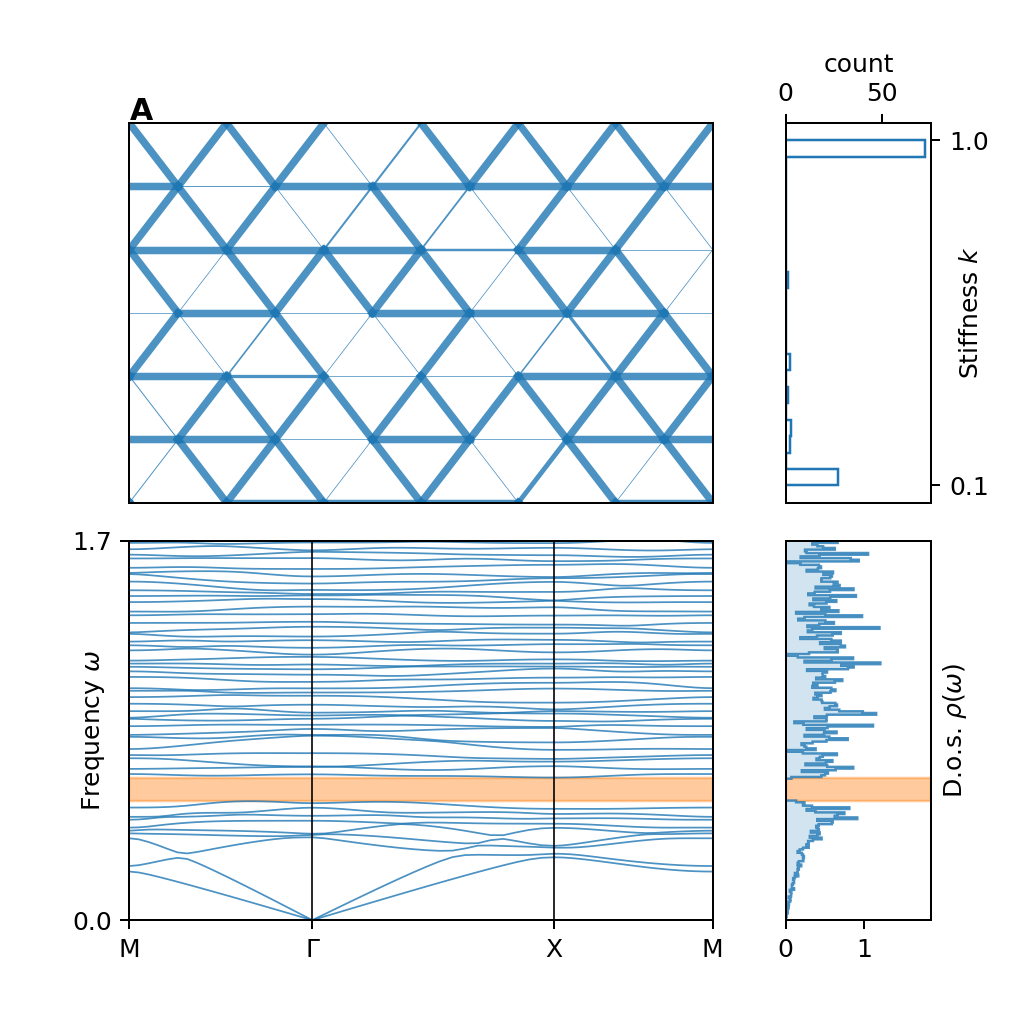

Text(0.0, 0.97, 'A')

In [28]:
f = plt.figure(figsize=(5.75, 5.75))

gs = gridspec.GridSpec(1, 1)


# 3 Gaps triangular grid
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, 
                                       wspace=0.2,
                                       hspace=0.1,
                                       width_ratios=[4,1],
                                       subplot_spec=gs[0,0])
ax_netw = plt.subplot(gs0[0,0])
ax_stiff = plt.subplot(gs0[0,1])
ax_bands = plt.subplot(gs0[1,0])
ax_dos = plt.subplot(gs0[1,1])

plot_result_2d(triang_grid, ret_triang_grid[0].x, ax_netw, ax_stiff, ax_bands, ax_dos, 
               show_gaps=opt_triang_grid.gap_inds, dos_bins=301)

ax_dos.set_yticks([])

ax_bands.set_ylim([0, 1.7])
ax_bands.set_yticks([0, 1.7])
ax_bands.set_ylabel('Frequency $\omega$', labelpad=-14)
ax_dos.set_ylim([0, 1.7])

ax_netw.set_title('A', loc='left', fontweight='bold', y=0.97)

